<a href="https://colab.research.google.com/github/MostafaTwfiq/Object-Detection/blob/open-images/open_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Dataset

In [ ]:
!pip install fiftyone

In [ ]:
!pip install torch torchvision

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz
import matplotlib.pyplot as plt
from fiftyone import ViewField as F
import torch
import torchvision
from PIL import Image
from torchvision.transforms import functional as func
import fiftyone as fo

In [ ]:
coco_dataset = foz.load_zoo_dataset("coco-2017", split="validation")

INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


Images already downloaded


INFO:fiftyone.utils.coco:Images already downloaded


Existing download of split 'validation' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'validation' is sufficient


Loading 'coco-2017' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'validation'


 100% |███████████████| 5000/5000 [38.9s elapsed, 0s remaining, 200.7 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [38.9s elapsed, 0s remaining, 200.7 samples/s]      


Dataset 'coco-2017-validation' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-validation' created


In [ ]:
classes = coco_dataset.default_classes

In [ ]:
dataset =  foz.load_zoo_dataset("voc-2012", split="validation")

Split 'validation' already downloaded


INFO:fiftyone.zoo.datasets:Split 'validation' already downloaded


Loading 'voc-2012' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'voc-2012' split 'validation'


 100% |███████████████| 5823/5823 [18.3s elapsed, 0s remaining, 294.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5823/5823 [18.3s elapsed, 0s remaining, 294.5 samples/s]      


Dataset 'voc-2012-validation' created


INFO:fiftyone.zoo.datasets:Dataset 'voc-2012-validation' created


In [ ]:
# Print some information about the dataset
print(dataset)

Name:        voc-2012-validation
Media type:  image
Num samples: 5823
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [ ]:
session = fo.launch_app(dataset)

## Object Detection Models


In [ ]:
# Run the model on GPU if it is available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:

# Load a pre-trained models
model_fasterrcnn_resnet50 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True);
model_fasterrcnn_resnet50.to(device)
model_fasterrcnn_resnet50.eval()


model_retinanet_resnet50_fpn = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True);
model_retinanet_resnet50_fpn.to(device)
model_retinanet_resnet50_fpn.eval()


model_ssd = torchvision.models.detection.ssd300_vgg16(pretrained=True);
model_ssd.to(device)
model_ssd.eval()

print("Models are ready")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_We

Models are ready


In [ ]:
predictions_view = dataset.take(1000,seed=51)

In [ ]:

def eval(model, predictions_view, save_model_name):


  # Get class list
  with fo.ProgressBar() as pb:
      for sample in pb(predictions_view):

          # Load image
          image = Image.open(sample.filepath)
          image = func.to_tensor(image).to(device)
          c, h, w = image.shape
          if len(image.shape) < 3 or c != 3:
            continue

          # Perform inference
          preds = model([image])[0]
          labels = preds["labels"].cpu().detach().numpy()
          scores = preds["scores"].cpu().detach().numpy()
          boxes = preds["boxes"].cpu().detach().numpy()

          # Convert detections to FiftyOne format
          detections = []
          for label, score, box in zip(labels, scores, boxes):
              # Convert to [top-left-x, top-left-y, width, height]
              # in relative coordinates in [0, 1] x [0, 1]
              x1, y1, x2, y2 = box
              rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

              detections.append(
                  fo.Detection(
                      label=classes[label],
                      bounding_box=rel_box,
                      confidence=score
                  )
              )

          # Save predictions to dataset
          sample[save_model_name] = fo.Detections(detections=detections)
          sample.save()

  print("Finished adding predictions")

In [ ]:
eval(model=model_fasterrcnn_resnet50, predictions_view=predictions_view, save_model_name='faster_rcnn')

 100% |███████████████| 1000/1000 [2.2m elapsed, 0s remaining, 7.7 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [2.2m elapsed, 0s remaining, 7.7 samples/s]      


Finished adding predictions


In [ ]:
eval(model=model_retinanet_resnet50_fpn, predictions_view=predictions_view, save_model_name='ratina_net')

 100% |███████████████| 1000/1000 [3.1m elapsed, 0s remaining, 5.8 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [3.1m elapsed, 0s remaining, 5.8 samples/s]       


Finished adding predictions


In [ ]:
eval(model=model_ssd, predictions_view=predictions_view, save_model_name='ssd_model')

 100% |███████████████| 1000/1000 [3.4m elapsed, 0s remaining, 5.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [3.4m elapsed, 0s remaining, 5.1 samples/s]      


Finished adding predictions


In [ ]:
session.view = predictions_view

In [ ]:
session.freeze()  # screenshot the active App for sharing

In [ ]:
def calc_map(result):
  print('mAP : ', result.mAP())
  result.print_report(classes=classes_sort)
  plot = result.plot_pr_curves(classes=classes_sort)
  plot.show()

# **1 - FasterRCNN Resnet50 Model**

Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 1000/1000 [1.6m elapsed, 0s remaining, 11.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [1.6m elapsed, 0s remaining, 11.6 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 1000/1000 [32.2s elapsed, 0s remaining, 20.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [32.2s elapsed, 0s remaining, 20.9 samples/s]      


mAP :  0.3706171828340157
              precision    recall  f1-score   support

      person       0.20      0.96      0.33       921
       chair       0.09      0.85      0.17       209
         car       0.19      0.97      0.32       237
         dog       0.25      0.97      0.39       139
      bottle       0.15      0.91      0.25        80
        bird       0.21      0.90      0.34        91
         cat       0.27      0.98      0.43       114
 pottedplant       0.00      0.00      0.00        69
        boat       0.12      0.96      0.22        77
       sheep       0.25      0.88      0.38        73
   aeroplane       0.00      0.00      0.00        80
   tvmonitor       0.00      0.00      0.00        59
        sofa       0.00      0.00      0.00        49
     bicycle       0.16      0.96      0.27        54
   motorbike       0.00      0.00      0.00        65
 diningtable       0.00      0.00      0.00        61
       horse       0.24      0.97      0.39        69
 

For confidence threshold None:
accuracy :  0.1749128341358127
precision :  0.18264563106796117
recall :  0.8051203668322506
fscore :  0.297746060905815


/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



{'fp': 21468, 'tp': 2107, 'fn': 510}
IOU Score 0.07101842613437011
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 1000/1000 [26.7s elapsed, 0s remaining, 35.7 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [26.7s elapsed, 0s remaining, 35.7 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 1000/1000 [10.7s elapsed, 0s remaining, 103.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [10.7s elapsed, 0s remaining, 103.9 samples/s]      


mAP :  0.35635901036310746
              precision    recall  f1-score   support

      person       0.60      0.91      0.72       921
       chair       0.35      0.61      0.45       209
         car       0.57      0.82      0.67       237
         dog       0.67      0.94      0.78       139
      bottle       0.44      0.74      0.55        80
        bird       0.71      0.84      0.77        91
         cat       0.78      0.93      0.85       114
 pottedplant       0.00      0.00      0.00        69
        boat       0.40      0.75      0.52        77
       sheep       0.67      0.66      0.66        73
   aeroplane       0.00      0.00      0.00        80
   tvmonitor       0.00      0.00      0.00        59
        sofa       0.00      0.00      0.00        49
     bicycle       0.54      0.91      0.68        54
   motorbike       0.00      0.00      0.00        65
 diningtable       0.00      0.00      0.00        61
       horse       0.69      0.88      0.77        69


For confidence threshold 0.5:
accuracy :  0.4729458917835671
precision :  0.5786086423536623
recall :  0.7214367596484524
fscore :  0.6421768707482994


/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



{'fp': 3477, 'fn': 729, 'tp': 1888}
IOU Score 0.2550200854765254
Number of predictions with confidence >= 0.5: 6094
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 1000/1000 [19.4s elapsed, 0s remaining, 63.2 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [19.4s elapsed, 0s remaining, 63.2 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 1000/1000 [8.6s elapsed, 0s remaining, 125.3 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [8.6s elapsed, 0s remaining, 125.3 samples/s]      


mAP :  0.341388339919358
              precision    recall  f1-score   support

      person       0.74      0.86      0.80       921
       chair       0.52      0.49      0.50       209
         car       0.72      0.74      0.73       237
         dog       0.85      0.87      0.86       139
      bottle       0.63      0.68      0.65        80
        bird       0.92      0.79      0.85        91
         cat       0.89      0.86      0.88       114
 pottedplant       0.00      0.00      0.00        69
        boat       0.56      0.62      0.59        77
       sheep       0.88      0.59      0.70        73
   aeroplane       0.00      0.00      0.00        80
   tvmonitor       0.00      0.00      0.00        59
        sofa       0.00      0.00      0.00        49
     bicycle       0.75      0.87      0.80        54
   motorbike       0.00      0.00      0.00        65
 diningtable       0.00      0.00      0.00        61
       horse       0.83      0.86      0.84        69
  

For confidence threshold 0.75:
accuracy :  0.5408258304874263
precision :  0.742540494458653
recall :  0.6656476881925869
fscore :  0.7019947612331251


/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



{'fp': 1666, 'fn': 875, 'tp': 1742}
IOU Score 0.3382186928547567
Number of predictions with confidence >= 0.75: 4283
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 1000/1000 [14.9s elapsed, 0s remaining, 61.0 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [14.9s elapsed, 0s remaining, 61.0 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 1000/1000 [8.4s elapsed, 0s remaining, 135.2 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [8.4s elapsed, 0s remaining, 135.2 samples/s]      


mAP :  0.31362659370047835
              precision    recall  f1-score   support

      person       0.85      0.80      0.83       921
       chair       0.72      0.39      0.50       209
         car       0.83      0.59      0.69       237
         dog       0.92      0.79      0.85       139
      bottle       0.69      0.51      0.59        80
        bird       0.96      0.73      0.83        91
         cat       0.97      0.79      0.87       114
 pottedplant       0.00      0.00      0.00        69
        boat       0.69      0.52      0.59        77
       sheep       0.93      0.53      0.68        73
   aeroplane       0.00      0.00      0.00        80
   tvmonitor       0.00      0.00      0.00        59
        sofa       0.00      0.00      0.00        49
     bicycle       0.84      0.78      0.81        54
   motorbike       0.00      0.00      0.00        65
 diningtable       0.00      0.00      0.00        61
       horse       0.93      0.80      0.86        69


For confidence threshold 0.9:
accuracy :  0.5405686546463245
precision :  0.8537787513691129
recall :  0.5957202904088651
fscore :  0.7017780778753094


/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



{'tp': 1559, 'fn': 1058, 'fp': 897}
IOU Score 0.3724426774605133
Number of predictions with confidence >= 0.9: 3514


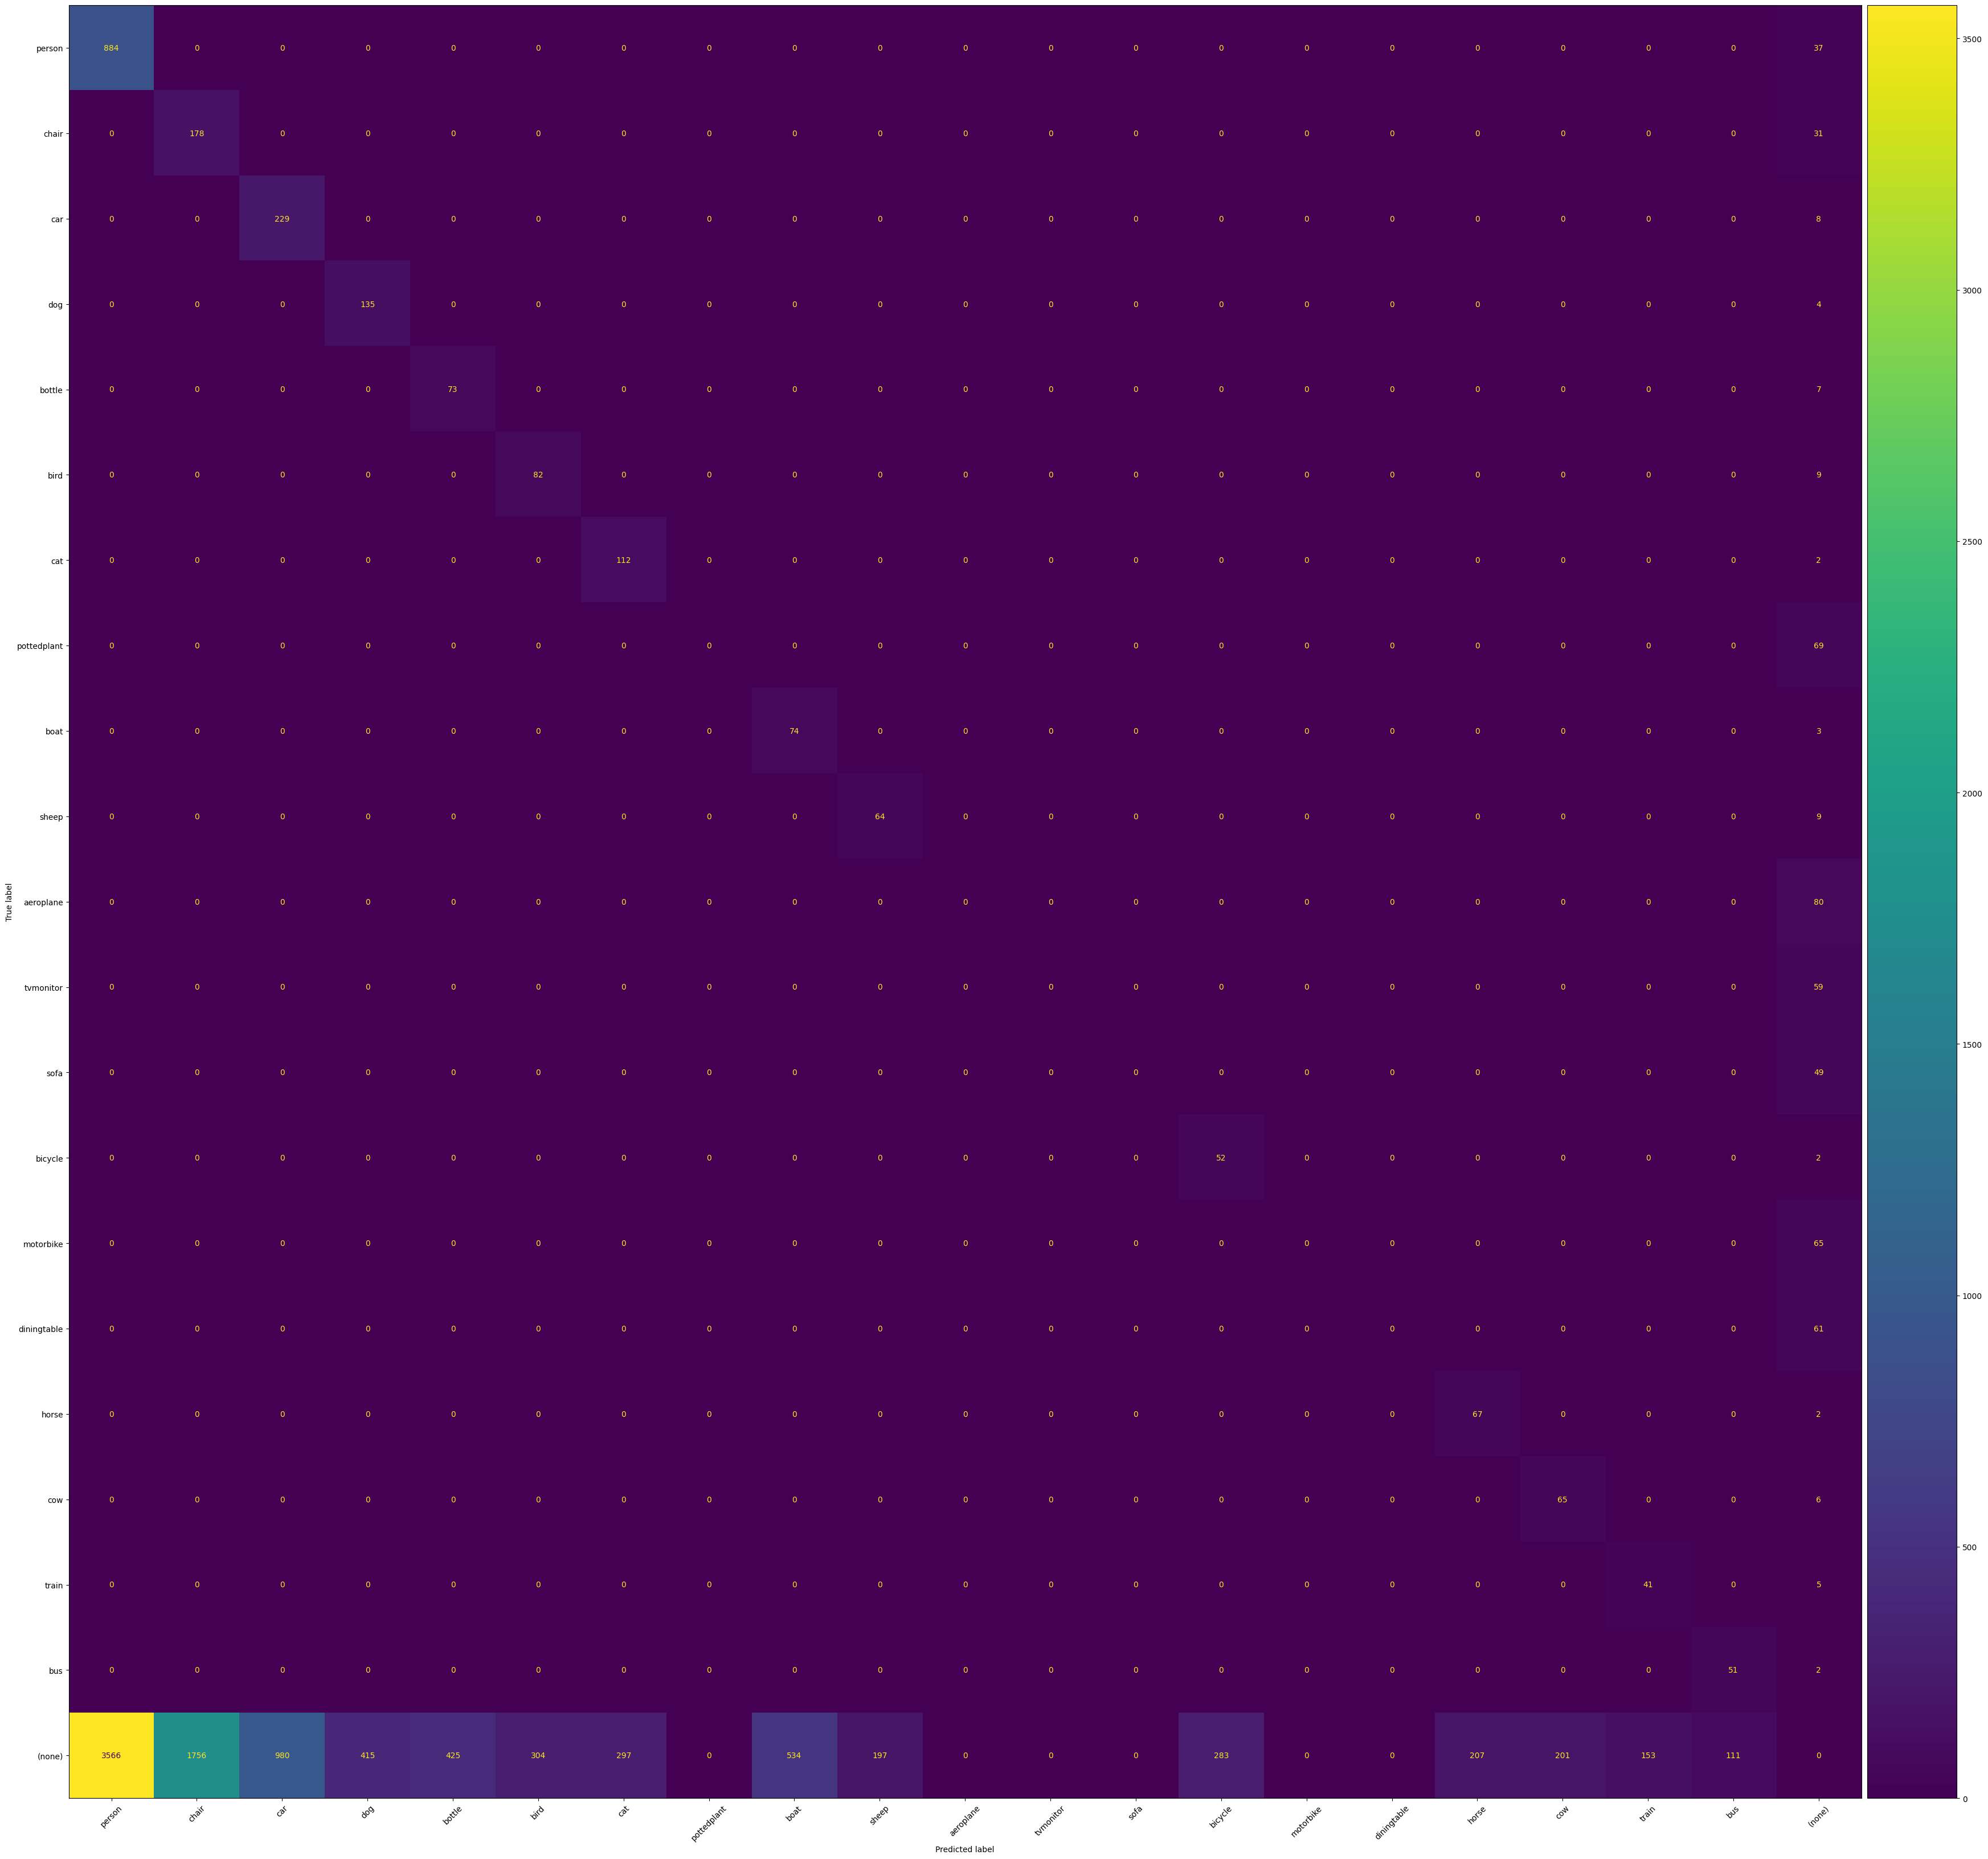

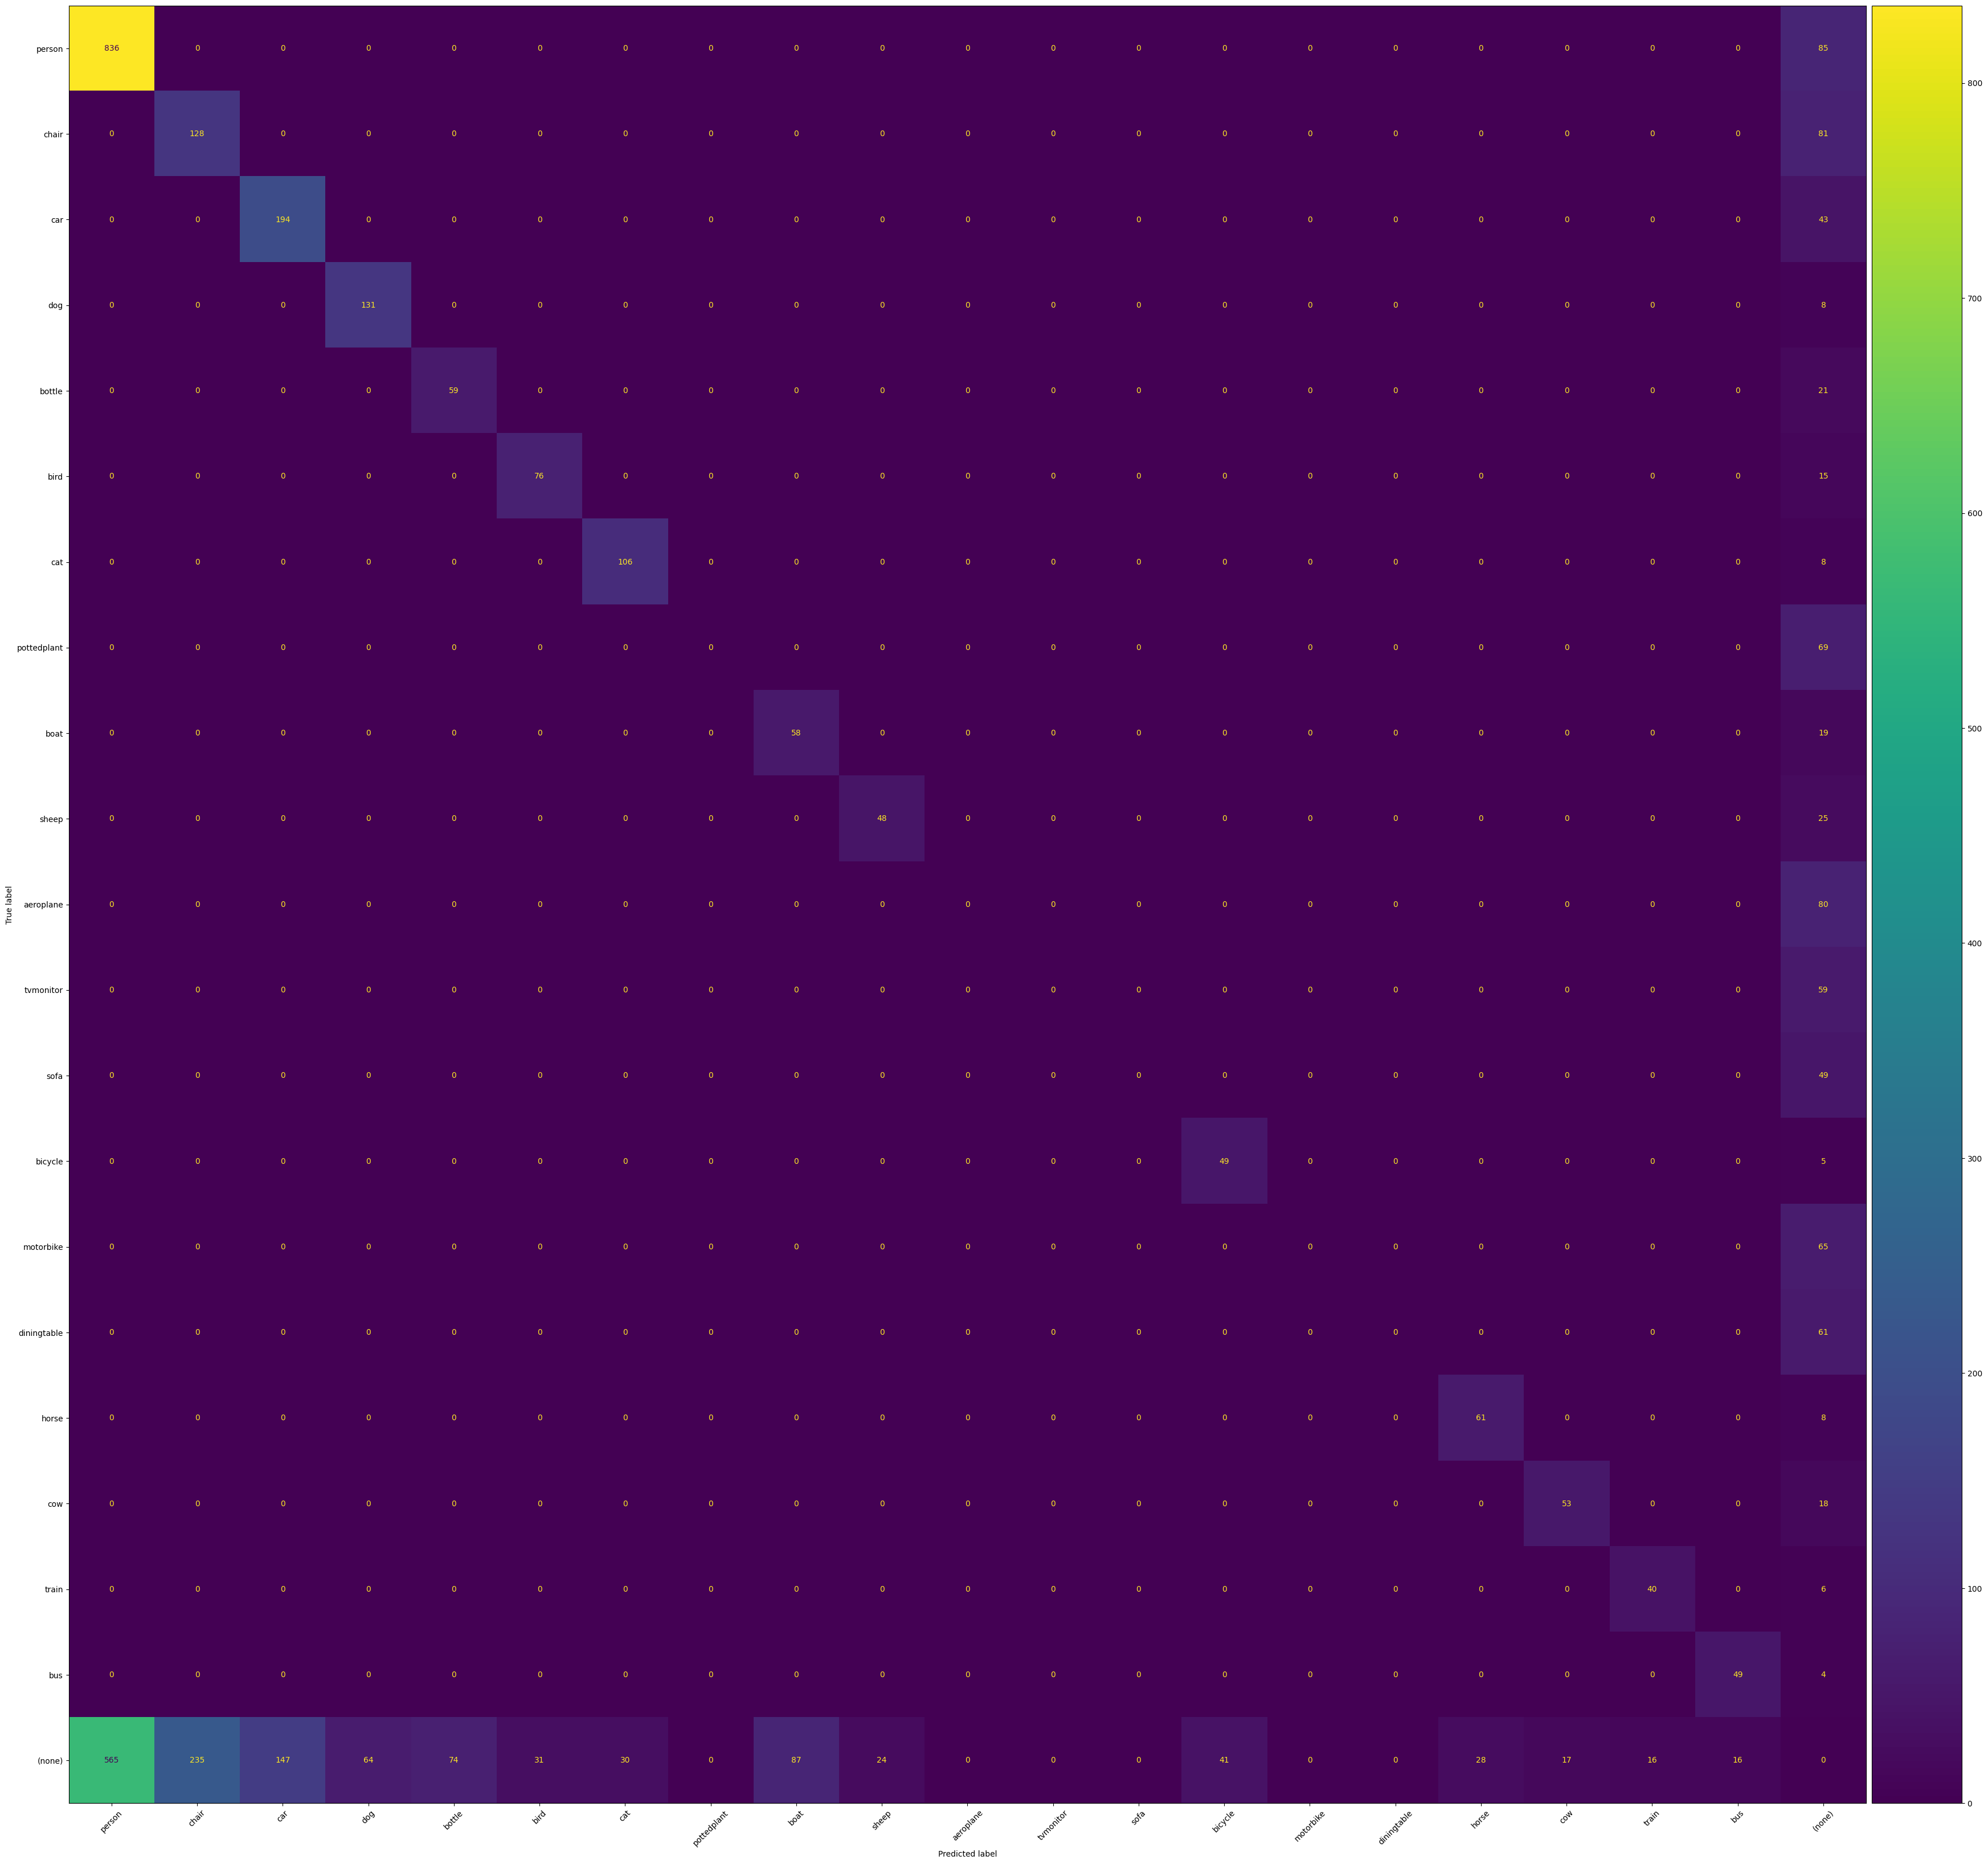

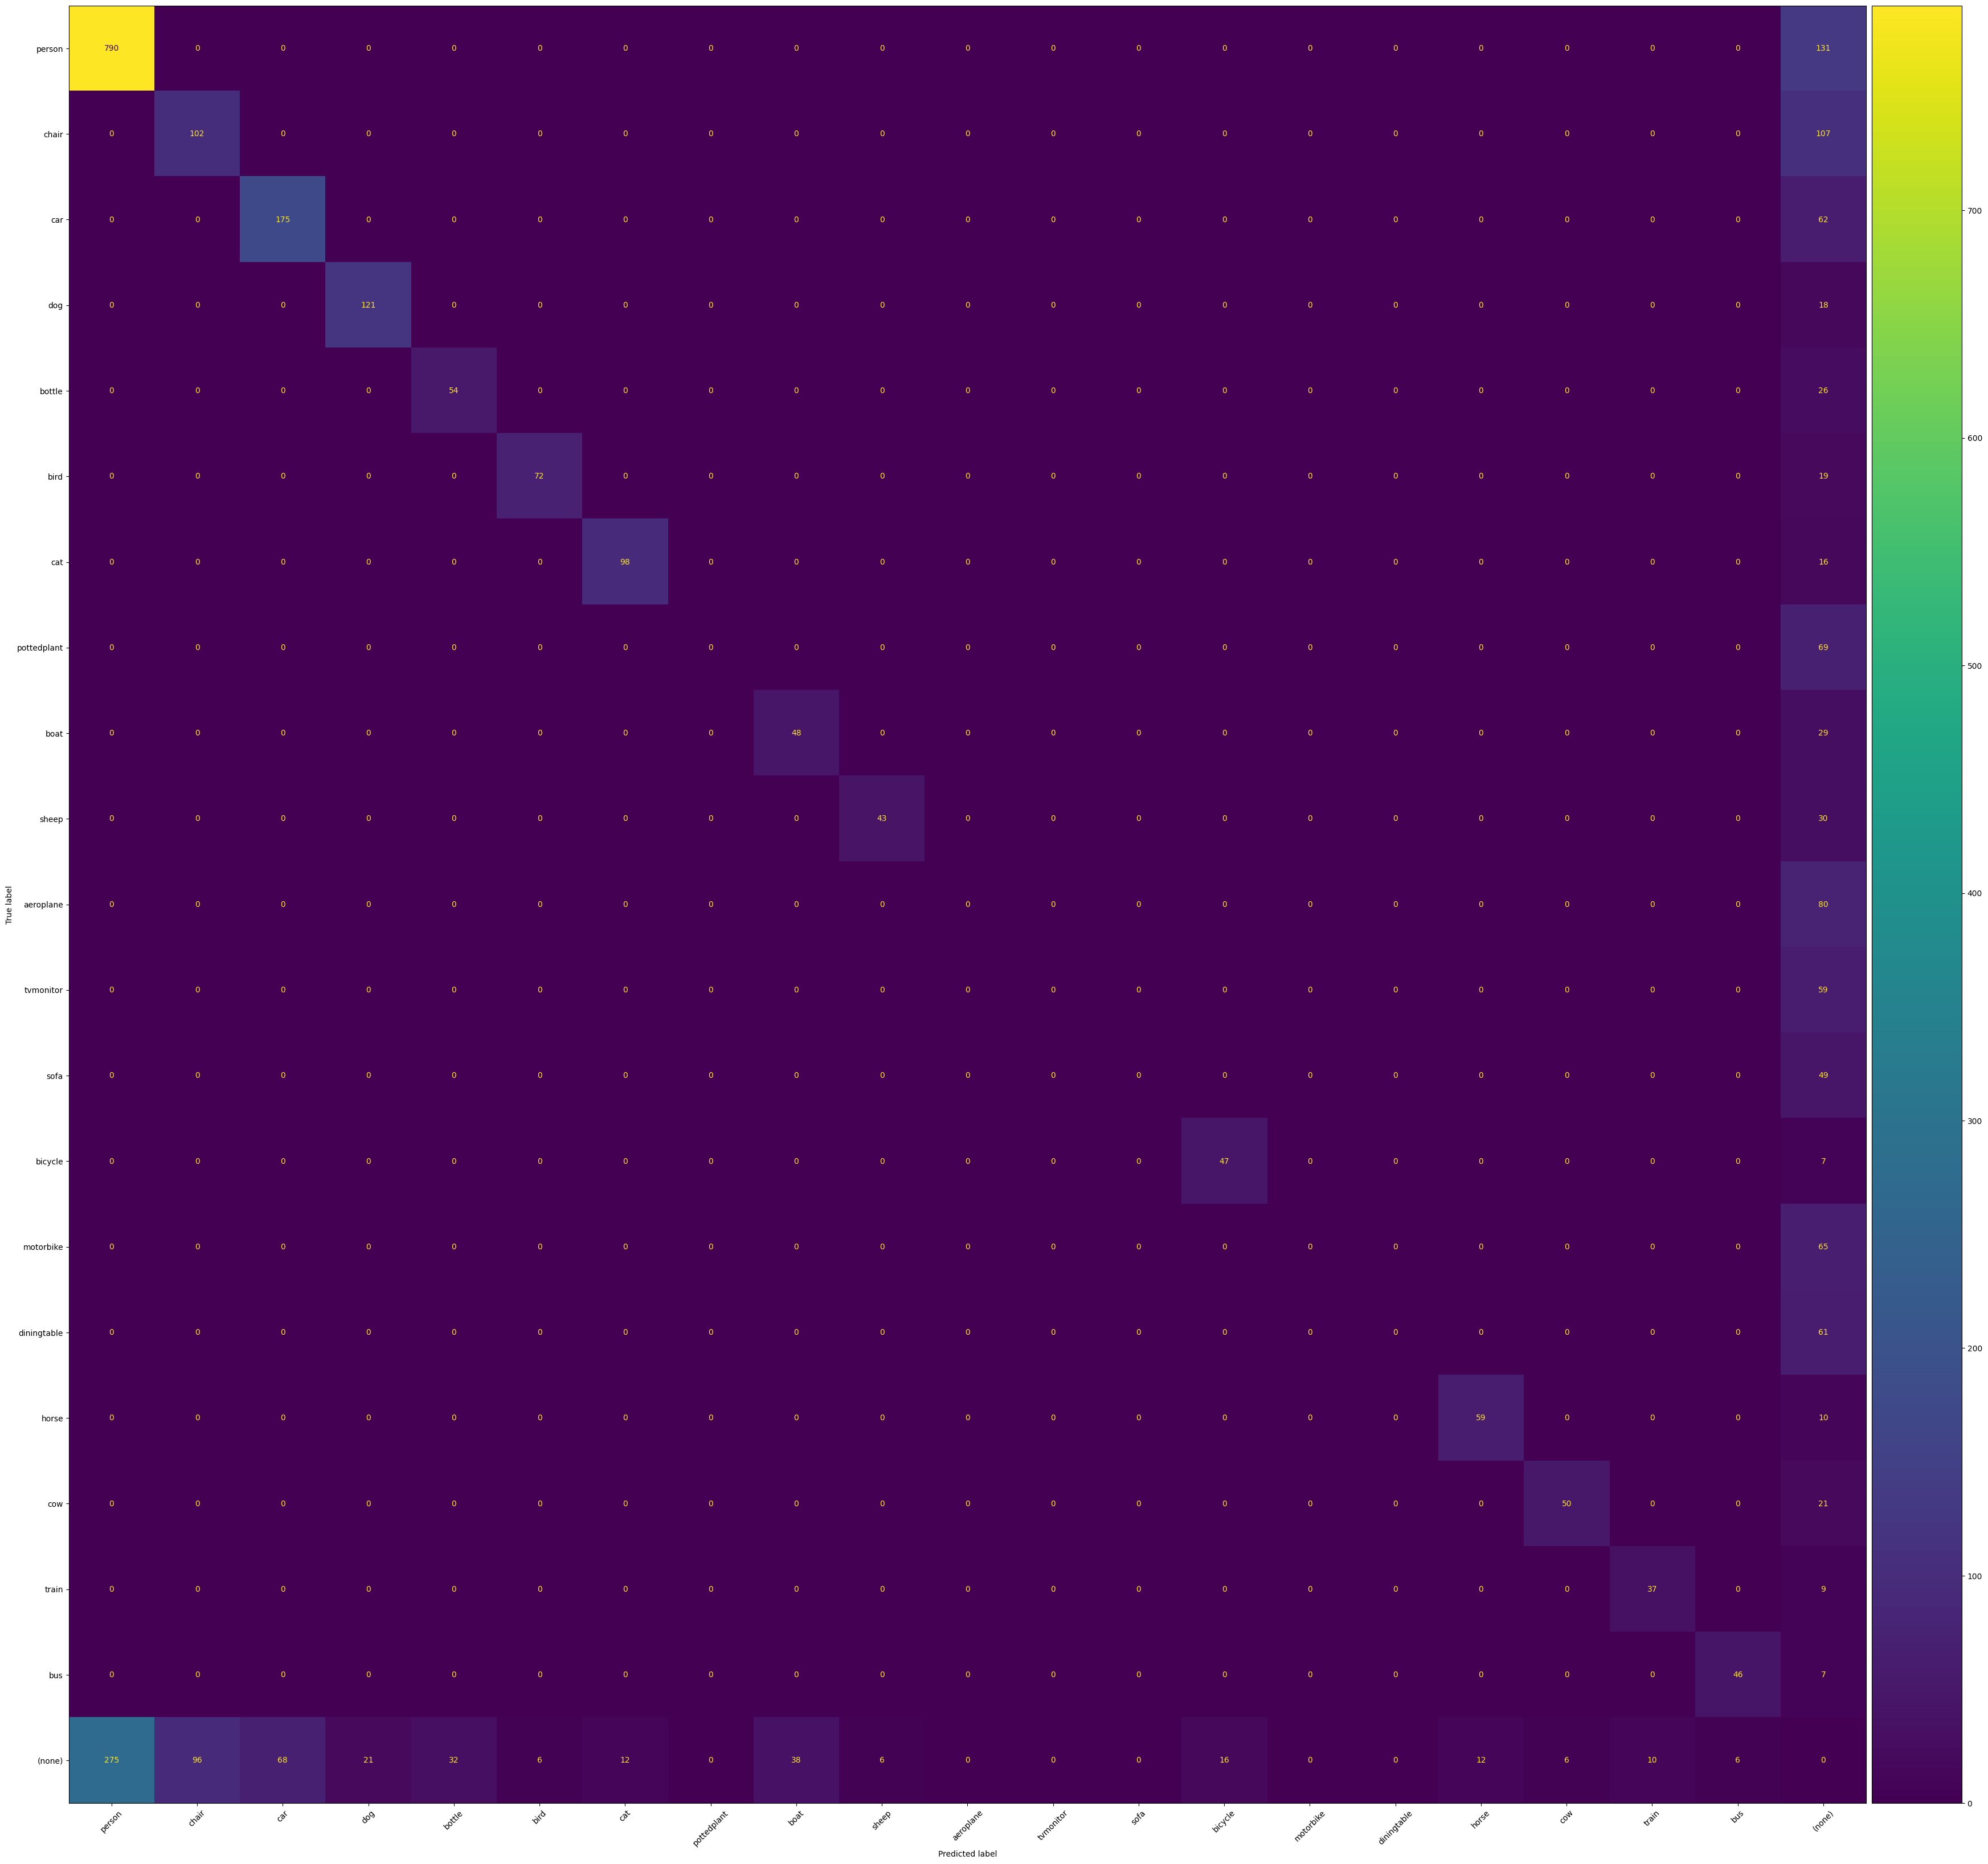

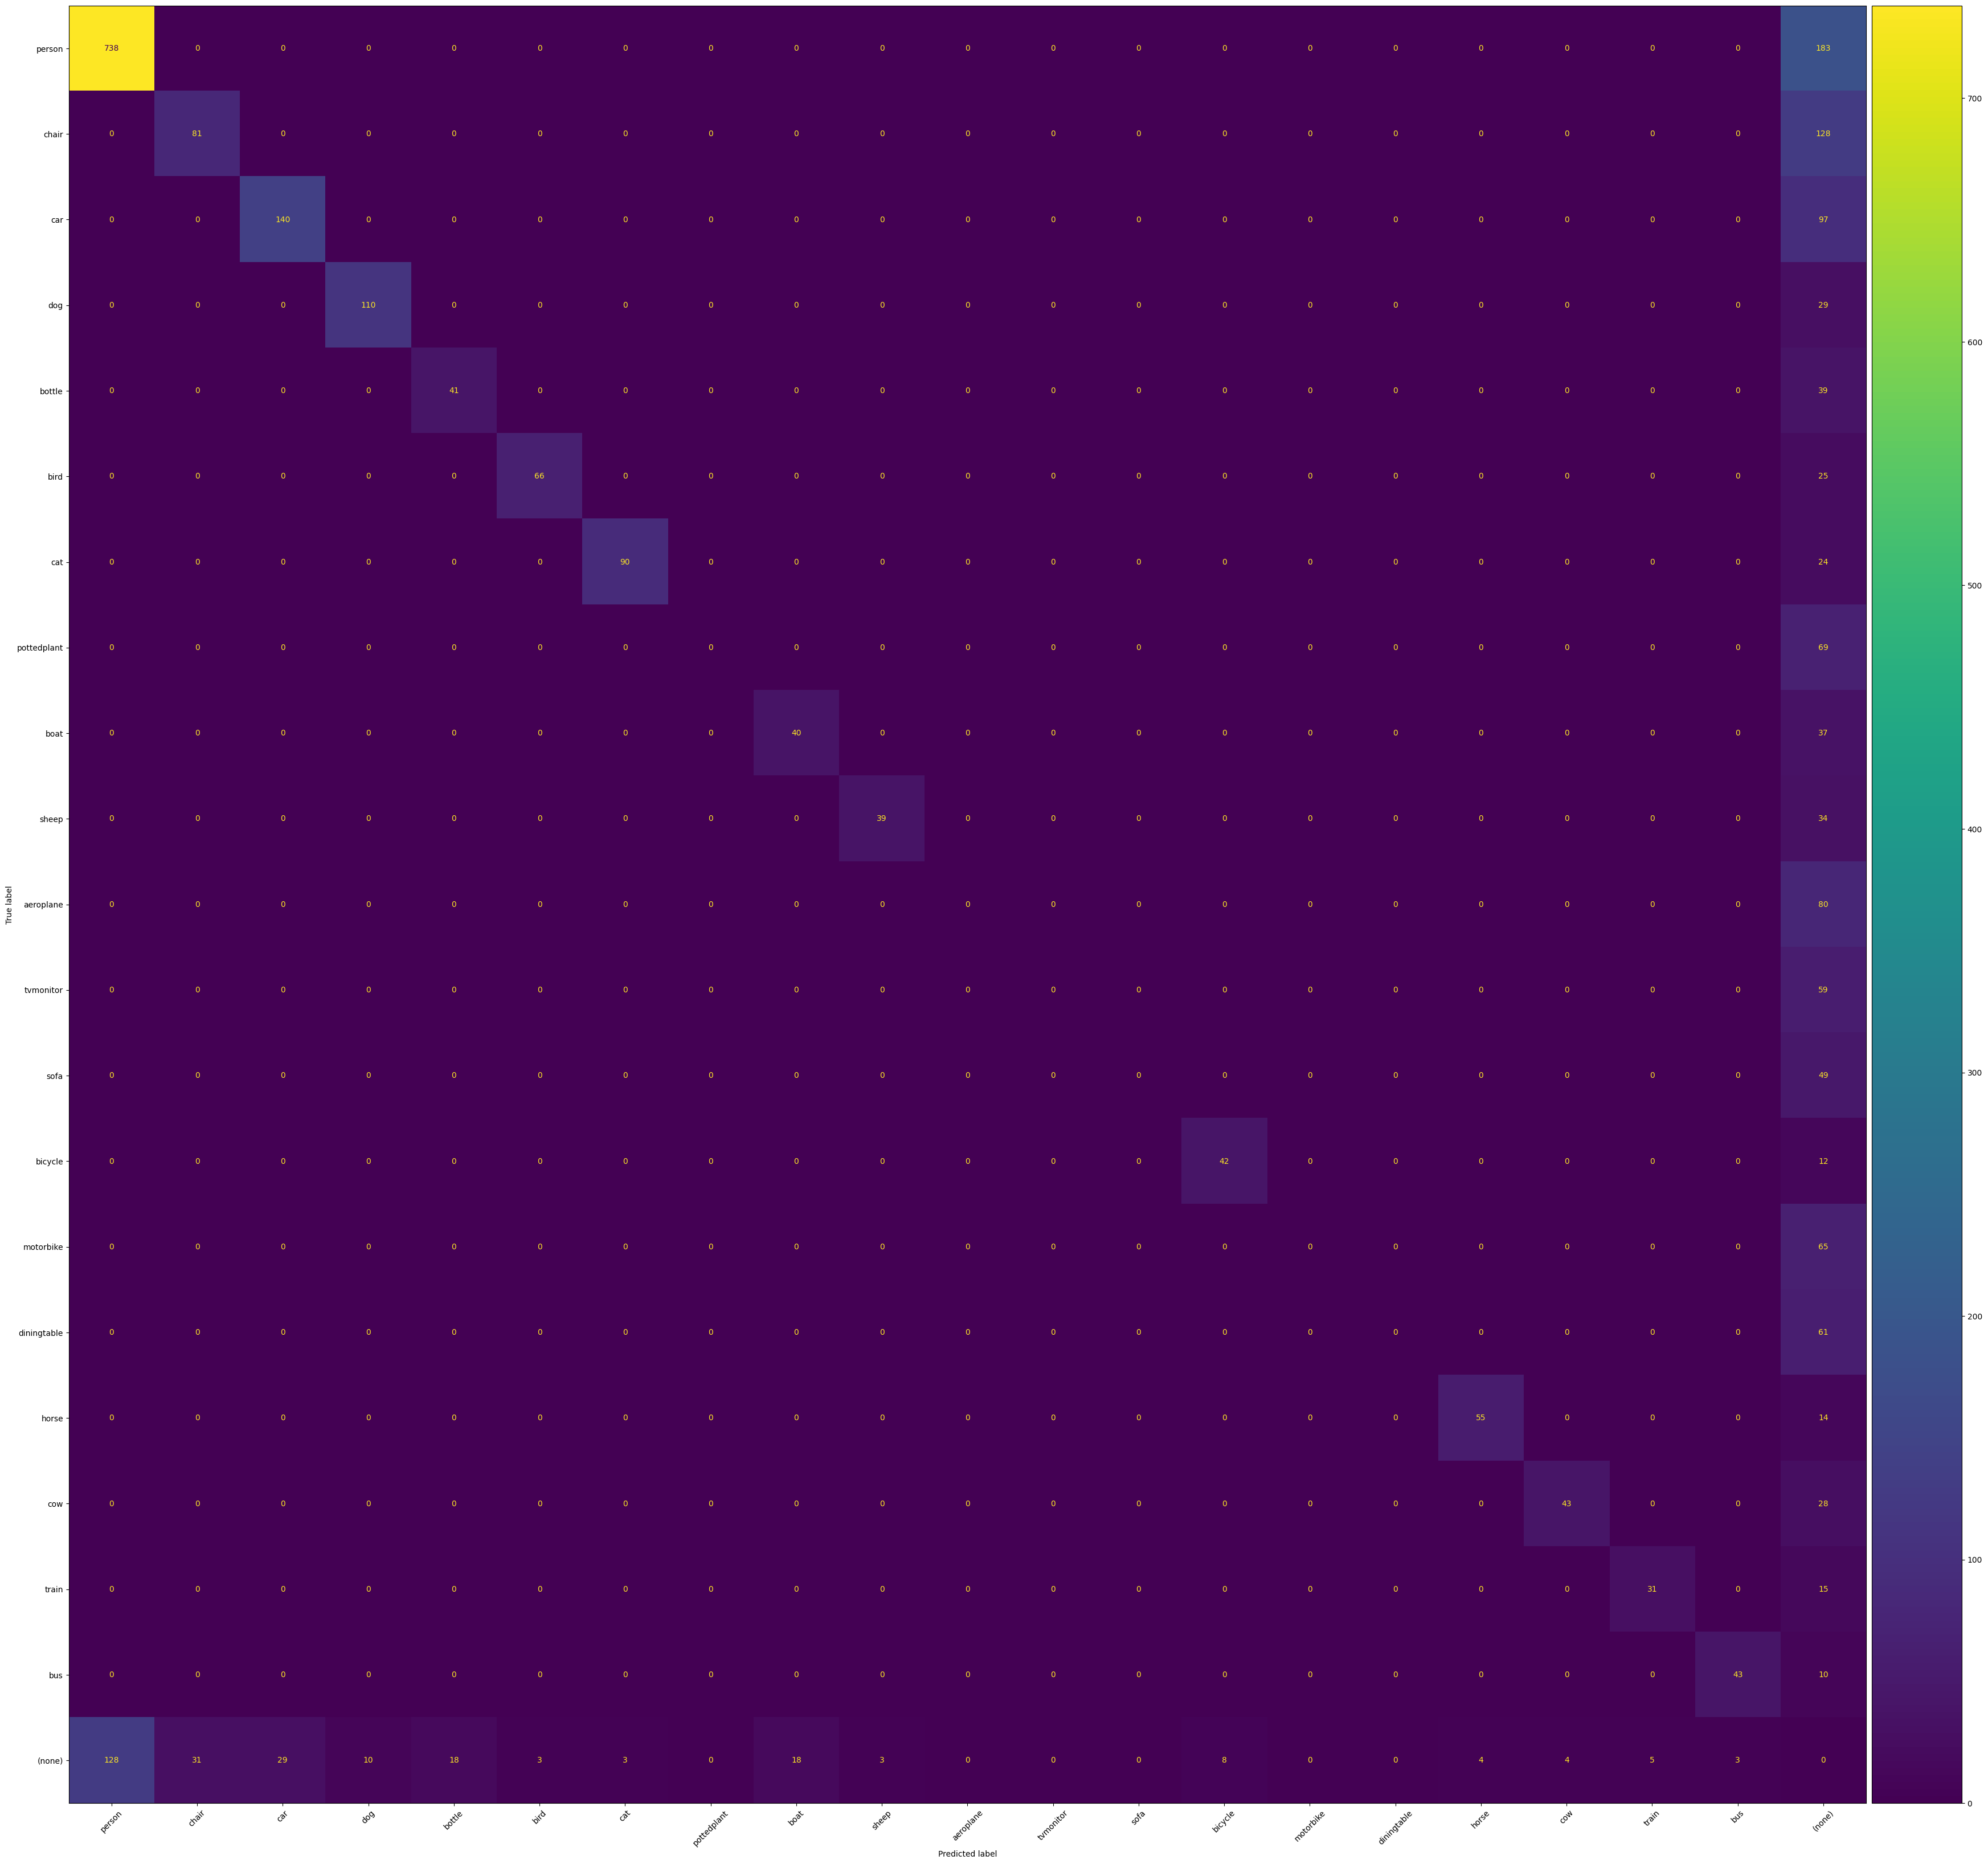

In [ ]:
from copy import deepcopy
counts = dataset.count_values("ground_truth.detections.label")
classes_sort = sorted(counts, key=counts.get, reverse=True)[:]
confidence_thresholds = [None, 0.5, 0.75,0.9]  # Include None for the initial evaluation without confidence filtering

for threshold in confidence_thresholds:
    if threshold is None:
        predictions_filtered = predictions_view
    else:
        predictions_filtered = predictions_view.filter_labels("faster_rcnn", F("confidence") >= threshold, only_matches=False)

    eval_result = predictions_filtered.evaluate_detections(
        "faster_rcnn",
        gt_field="ground_truth",
        eval_key="eval",
        compute_mAP=True,
    )

    calc_map(eval_result)

    d = eval_result.metrics(classes_sort)
    acc = d['accuracy']
    pre = d['precision']
    rec = d['recall']
    fsc = d['fscore']

    print(f'For confidence threshold {threshold}:')
    print('accuracy : ', acc)
    print('precision : ', pre)
    print('recall : ', rec)
    print('fscore : ', fsc)

    plot = eval_result.plot_confusion_matrix(classes=classes_sort[:], backend="matplotlib", figsize=(35, 35))
    plot.show()

    plot = eval_result.plot_confusion_matrix(classes=classes_sort[:10])
    plot.show()

    eval_patches = predictions_filtered.to_evaluation_patches("eval")
    print(eval_patches.count_values("type"))

    iou = eval_patches.count_values('iou')
    x = list(iou.items())
    sum_iou = 0.0
    for i, v in x:
        if not i:
            continue
        sum_iou += (i * v)

    print('IOU Score', sum_iou / sum(iou.values()))

    if threshold is not None:
        print(f"Number of predictions with confidence >= {threshold}: {sum(iou.values())}")


# **2 - ratinaNet Model**

Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 1000/1000 [20.6m elapsed, 0s remaining, 0.7 samples/s]    


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [20.6m elapsed, 0s remaining, 0.7 samples/s]    


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 1000/1000 [2.2m elapsed, 0s remaining, 4.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [2.2m elapsed, 0s remaining, 4.4 samples/s]      


mAP :  0.3962926641372029
              precision    recall  f1-score   support

      person       0.05      0.98      0.10       921
       chair       0.03      0.92      0.05       209
         car       0.04      0.98      0.09       237
         dog       0.11      0.99      0.19       139
      bottle       0.03      0.91      0.06        80
        bird       0.06      0.95      0.11        91
         cat       0.11      0.99      0.21       114
 pottedplant       0.00      0.00      0.00        69
        boat       0.03      0.94      0.05        77
       sheep       0.08      0.95      0.15        73
   aeroplane       0.00      0.00      0.00        80
   tvmonitor       0.00      0.00      0.00        59
        sofa       0.00      0.00      0.00        49
     bicycle       0.04      0.98      0.08        54
   motorbike       0.00      0.00      0.00        65
 diningtable       0.00      0.00      0.00        61
       horse       0.06      0.97      0.12        69
 

For confidence threshold None:
accuracy :  0.0489610537072783
precision :  0.04947904713820168
recall :  0.8238440962934658
fscore :  0.0933515186941179


/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



{None: 21119, 'fp': 897, 'fn': 1058, 'tp': 1559}
IOU Score 0.053130498461261104
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 1000/1000 [17.2s elapsed, 0s remaining, 52.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [17.2s elapsed, 0s remaining, 52.9 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 1000/1000 [11.1s elapsed, 0s remaining, 127.8 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [11.1s elapsed, 0s remaining, 127.8 samples/s]      


mAP :  0.35878097826866184
              precision    recall  f1-score   support

      person       0.81      0.82      0.82       921
       chair       0.68      0.43      0.53       209
         car       0.83      0.74      0.78       237
         dog       0.83      0.91      0.87       139
      bottle       0.62      0.45      0.52        80
        bird       0.89      0.82      0.86        91
         cat       0.89      0.90      0.90       114
 pottedplant       0.00      0.00      0.00        69
        boat       0.69      0.52      0.59        77
       sheep       0.84      0.63      0.72        73
   aeroplane       0.00      0.00      0.00        80
   tvmonitor       0.00      0.00      0.00        59
        sofa       0.00      0.00      0.00        49
     bicycle       0.78      0.85      0.81        54
   motorbike       0.00      0.00      0.00        65
 diningtable       0.00      0.00      0.00        61
       horse       0.79      0.84      0.82        69


For confidence threshold 0.5:
accuracy :  0.5560701290109163
precision :  0.8054623862002875
recall :  0.642338555598013
fscore :  0.7147108843537415


/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



{'fp': 897, 'tp': 1559, 'fn': 1058, None: 21119}
IOU Score 0.05313049846126114
Number of predictions with confidence >= 0.5: 24633
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 1000/1000 [12.3s elapsed, 0s remaining, 96.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [12.3s elapsed, 0s remaining, 96.4 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 1000/1000 [8.9s elapsed, 0s remaining, 147.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [8.9s elapsed, 0s remaining, 147.5 samples/s]      


mAP :  0.2860633153581664
              precision    recall  f1-score   support

      person       0.96      0.56      0.71       921
       chair       0.97      0.13      0.24       209
         car       0.97      0.43      0.60       237
         dog       0.94      0.75      0.83       139
      bottle       0.83      0.12      0.22        80
        bird       0.97      0.69      0.81        91
         cat       0.97      0.73      0.83       114
 pottedplant       0.00      0.00      0.00        69
        boat       0.92      0.30      0.45        77
       sheep       1.00      0.45      0.62        73
   aeroplane       0.00      0.00      0.00        80
   tvmonitor       0.00      0.00      0.00        59
        sofa       0.00      0.00      0.00        49
     bicycle       0.97      0.70      0.82        54
   motorbike       0.00      0.00      0.00        65
 diningtable       0.00      0.00      0.00        61
       horse       0.96      0.65      0.78        69
 

For confidence threshold 0.75:
accuracy :  0.43199700262270513
precision :  0.9568464730290457
recall :  0.44058081773022545
fscore :  0.6033490319204605


/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



{'fn': 1058, 'tp': 1559, 'fp': 897, None: 21119}
IOU Score 0.0531304984612611
Number of predictions with confidence >= 0.75: 24633
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 1000/1000 [10.2s elapsed, 0s remaining, 85.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [10.2s elapsed, 0s remaining, 85.5 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 1000/1000 [6.0s elapsed, 0s remaining, 179.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [6.0s elapsed, 0s remaining, 179.5 samples/s]      


mAP :  0.17262474930582622
              precision    recall  f1-score   support

      person       0.99      0.26      0.41       921
       chair       1.00      0.02      0.04       209
         car       1.00      0.08      0.14       237
         dog       1.00      0.35      0.52       139
      bottle       0.00      0.00      0.00        80
        bird       1.00      0.55      0.71        91
         cat       1.00      0.33      0.50       114
 pottedplant       0.00      0.00      0.00        69
        boat       1.00      0.13      0.23        77
       sheep       1.00      0.23      0.38        73
   aeroplane       0.00      0.00      0.00        80
   tvmonitor       0.00      0.00      0.00        59
        sofa       0.00      0.00      0.00        49
     bicycle       1.00      0.30      0.46        54
   motorbike       0.00      0.00      0.00        65
 diningtable       0.00      0.00      0.00        61
       horse       0.97      0.45      0.61        69


For confidence threshold 0.9:
accuracy :  0.20984357115604732
precision :  0.9927797833935018
recall :  0.21016431027894536
fscore :  0.3468937243771681


/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



{'fn': 1058, 'tp': 1559, 'fp': 897, None: 21119}
IOU Score 0.0531304984612611
Number of predictions with confidence >= 0.9: 24633


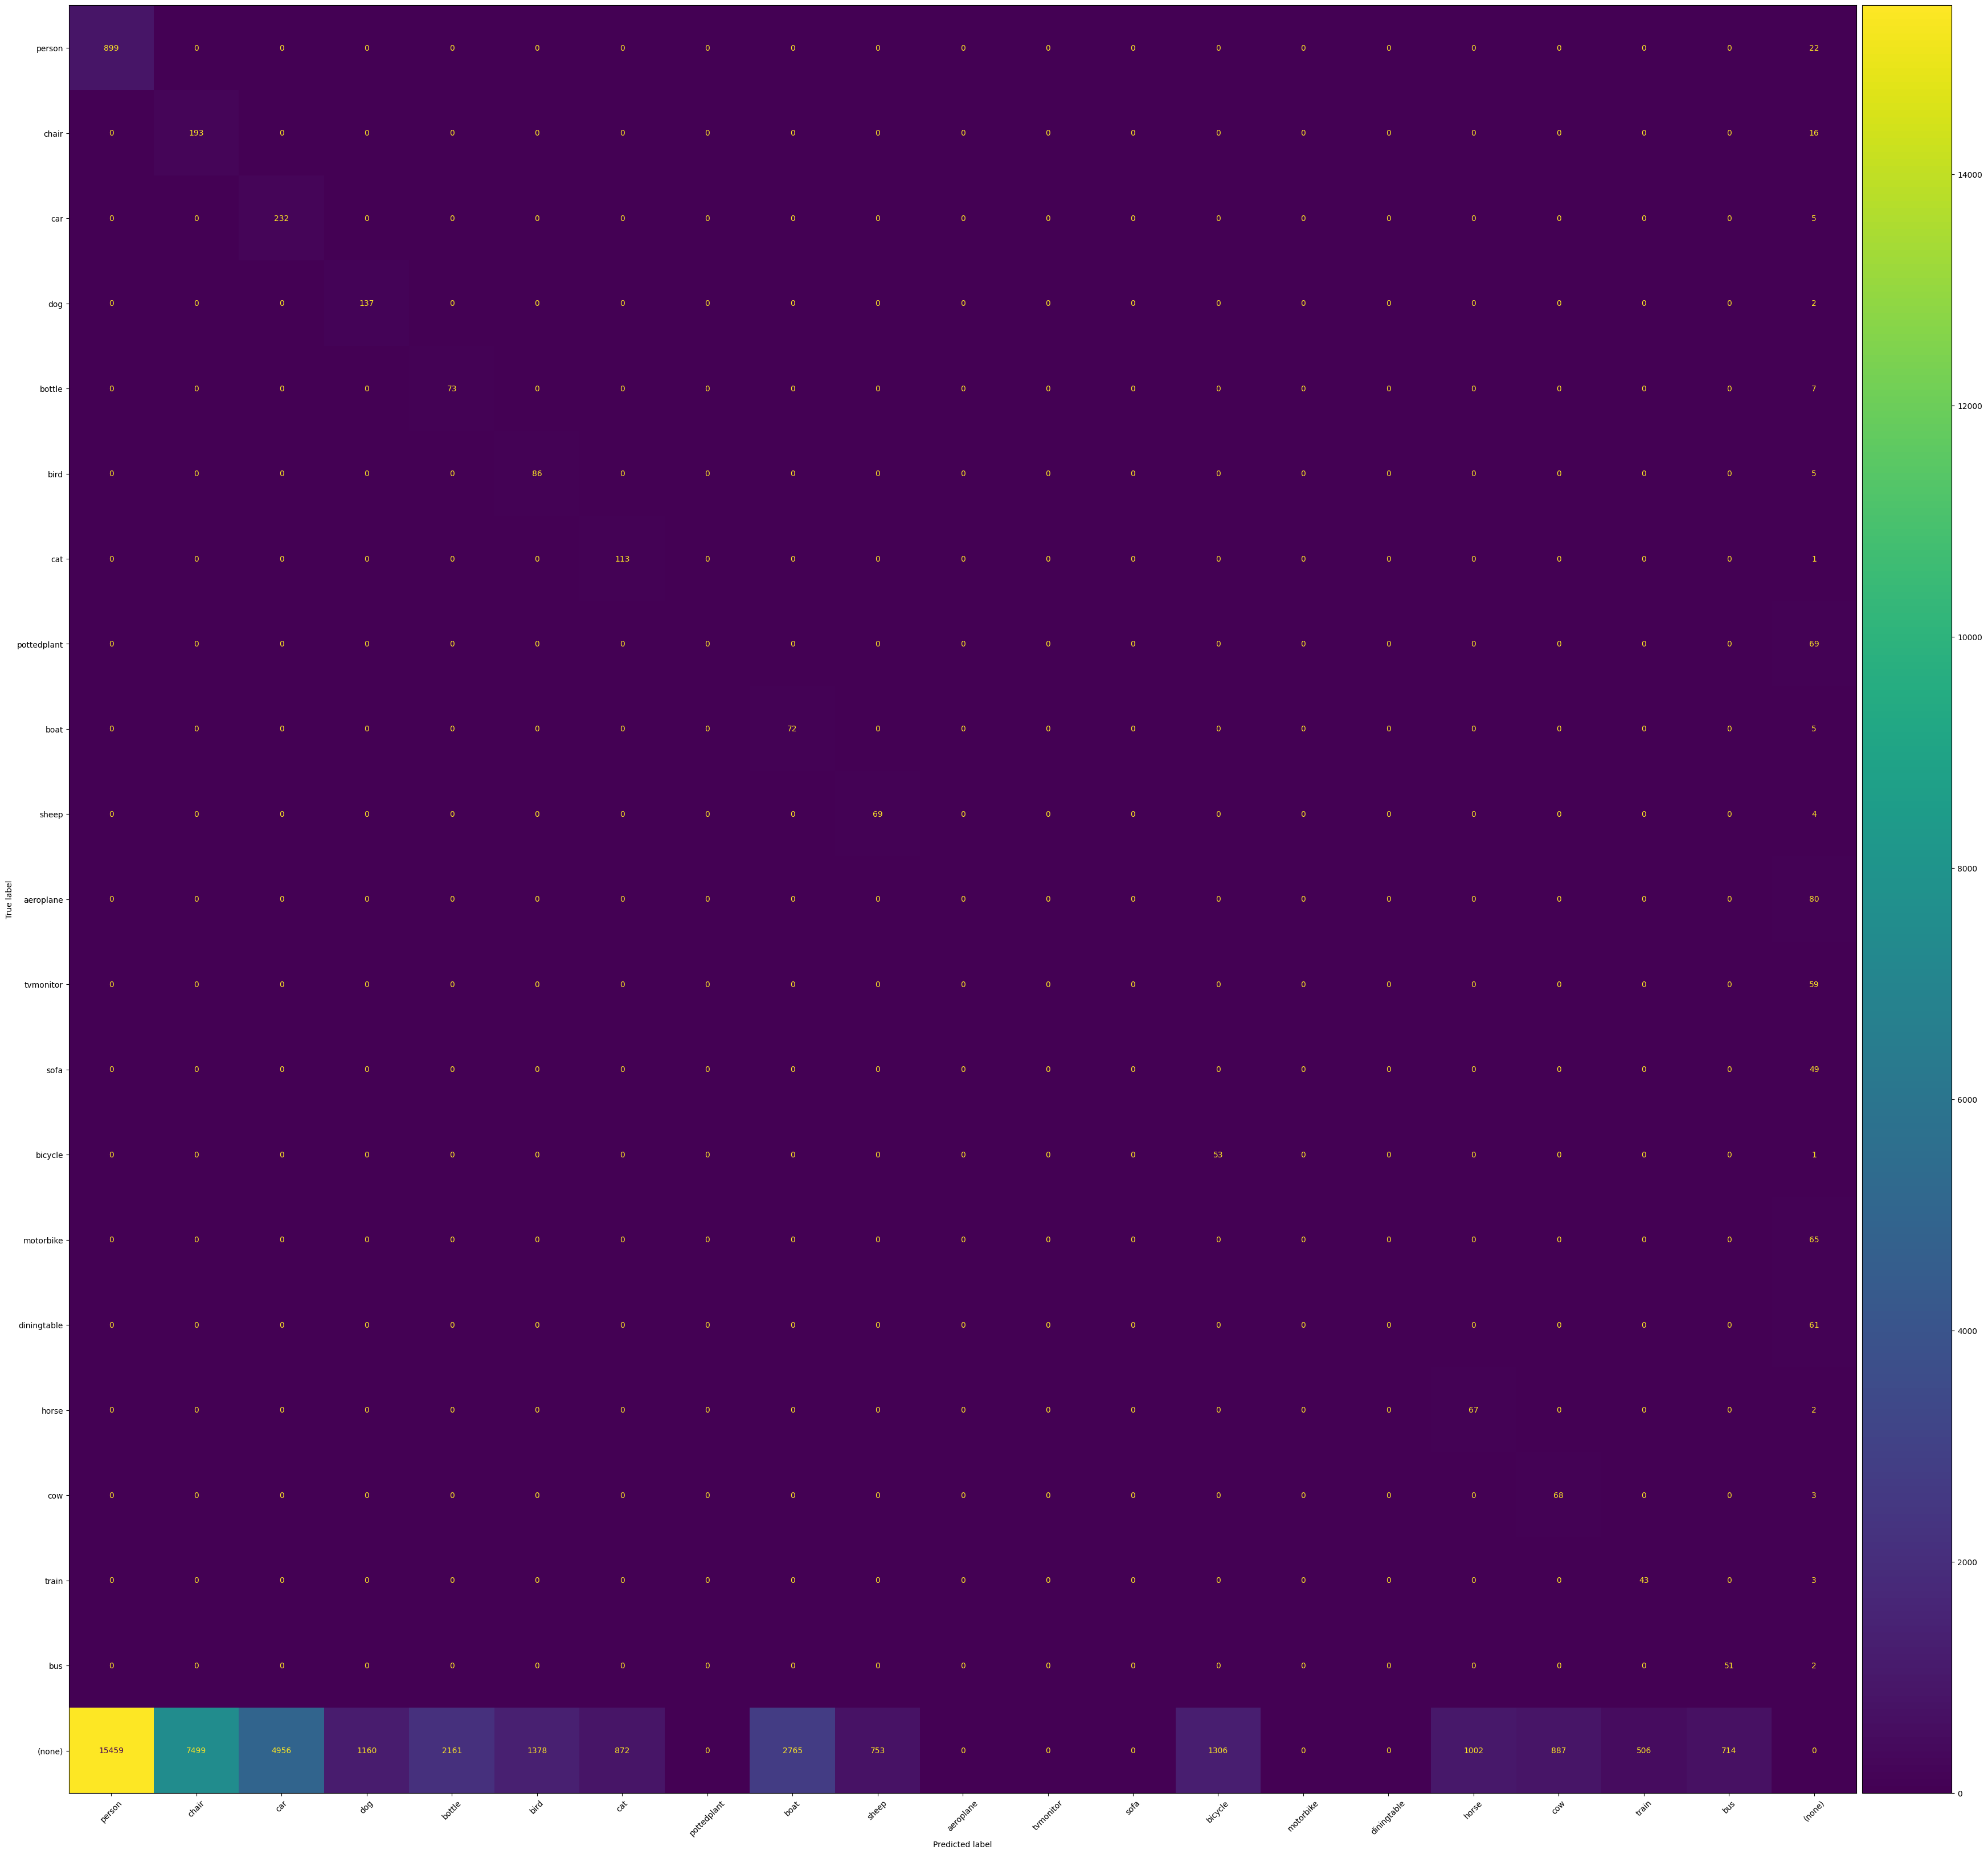

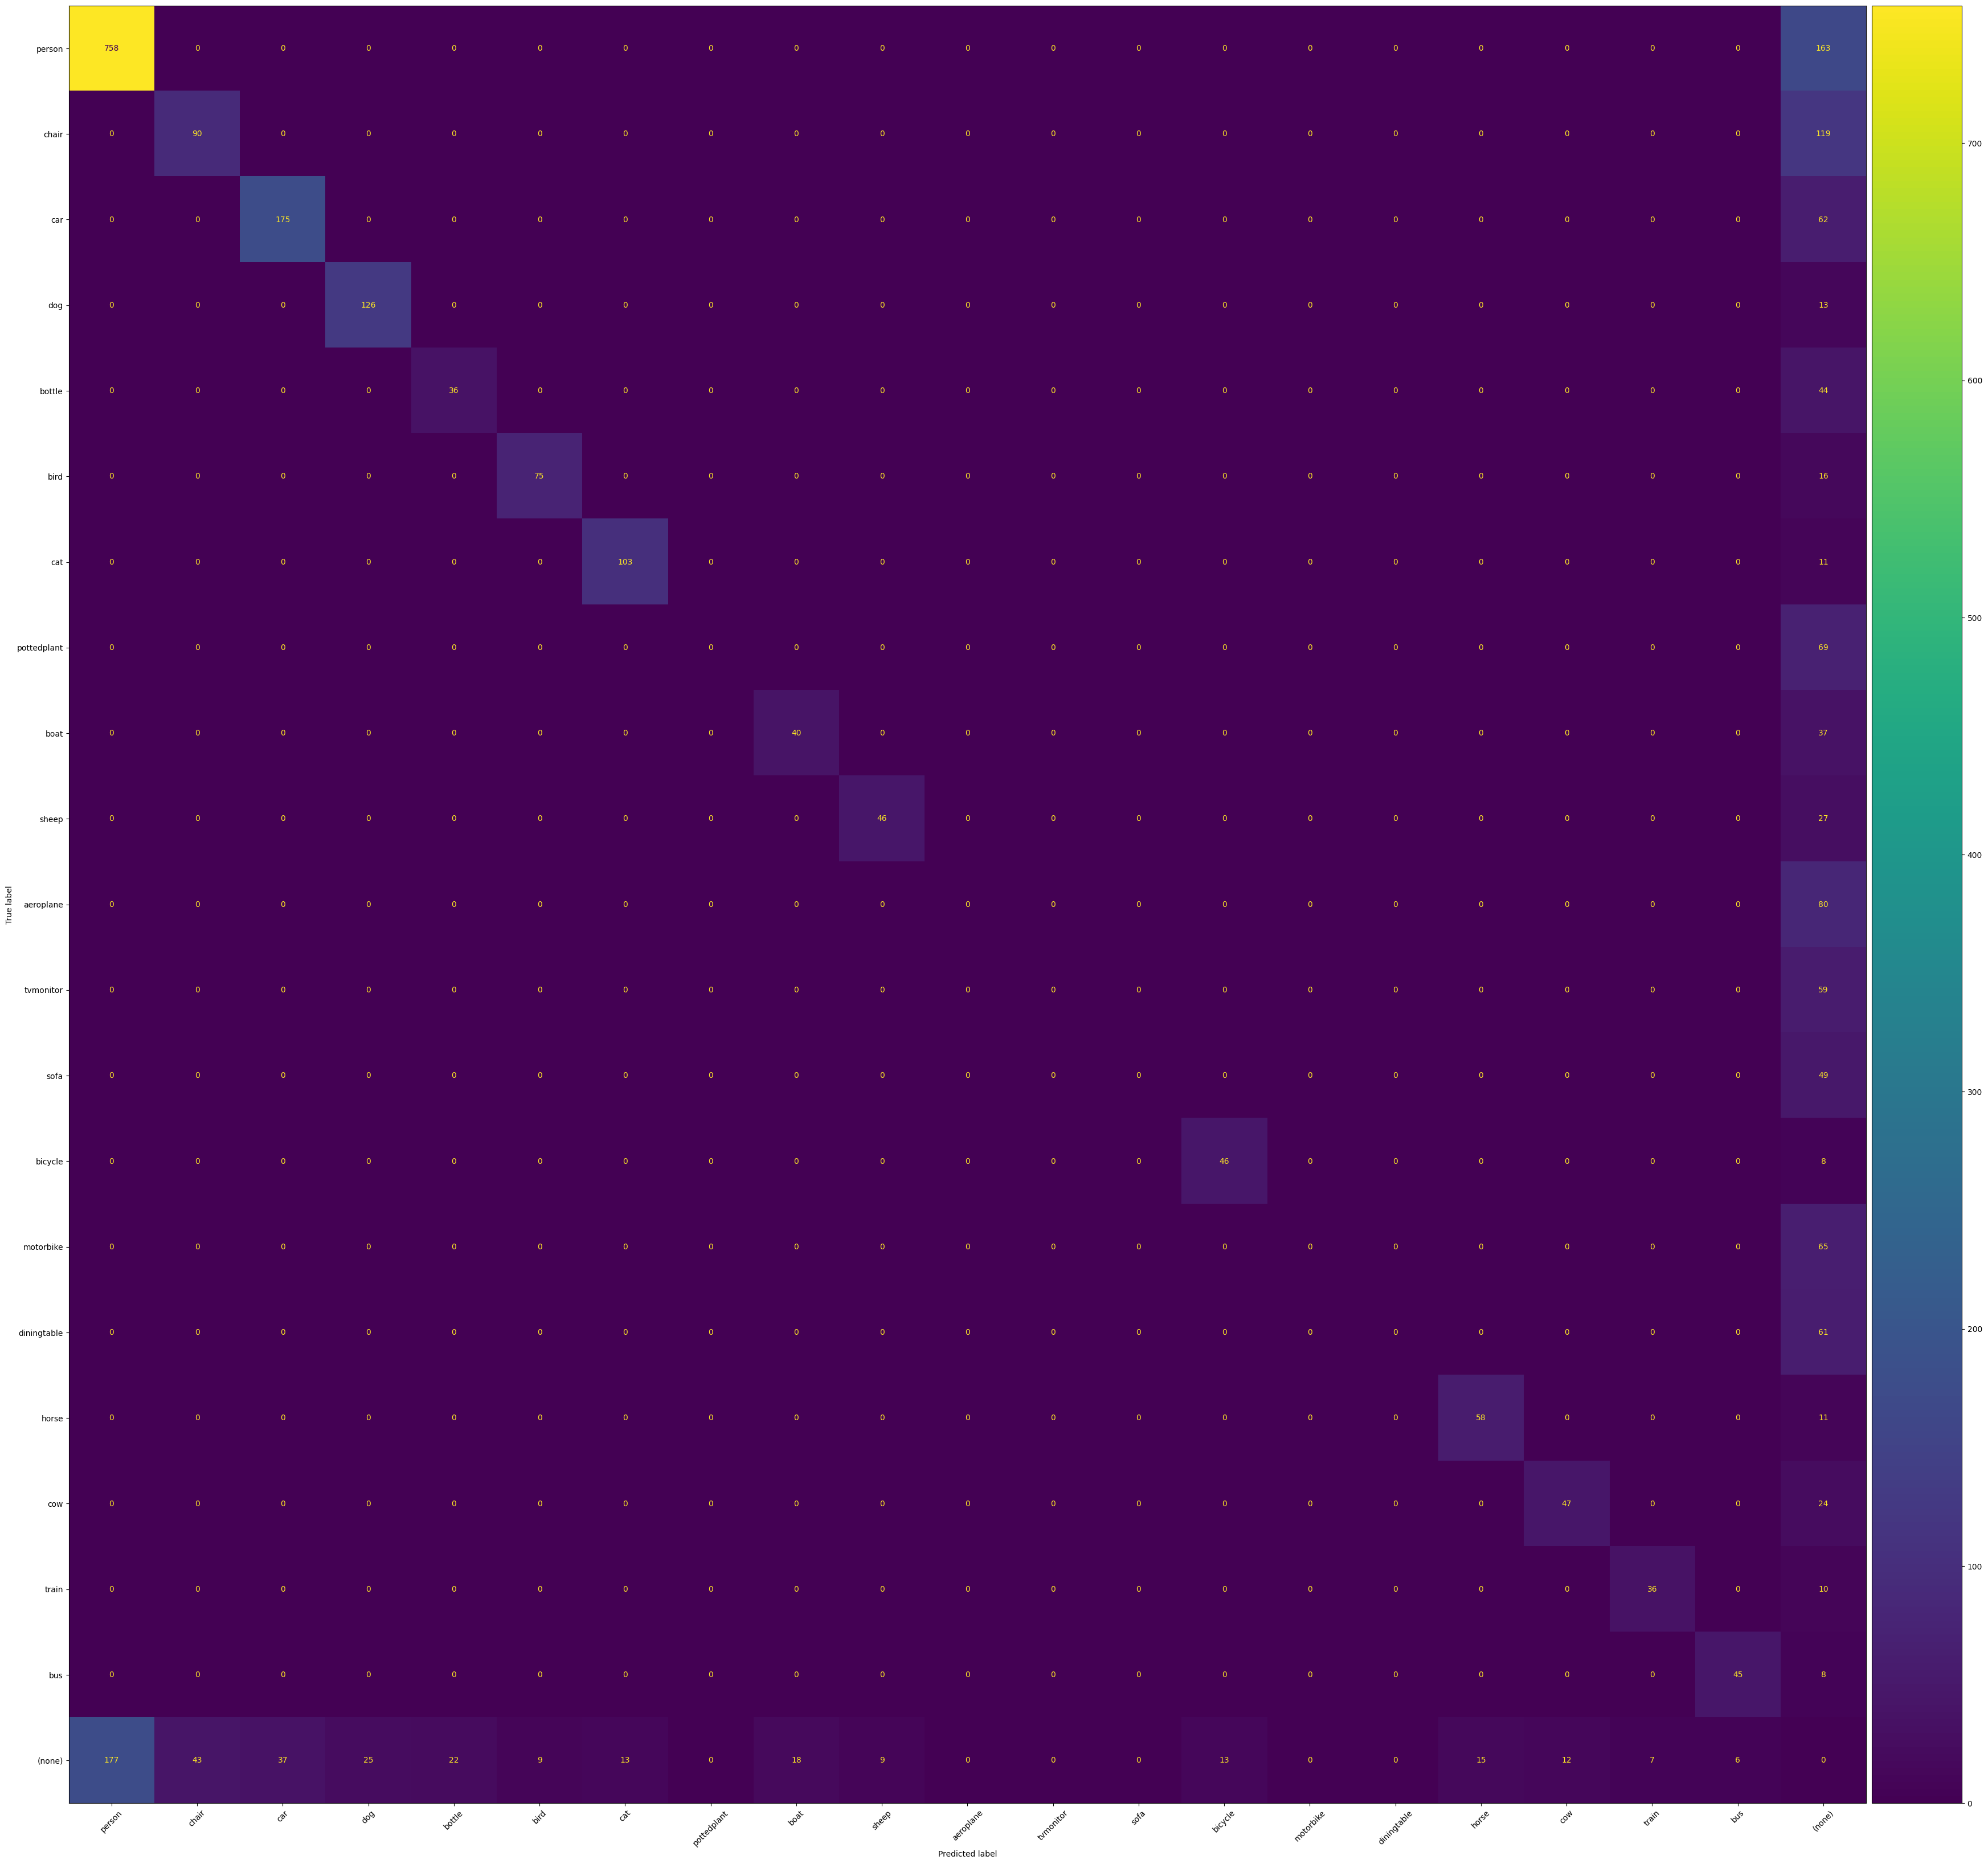

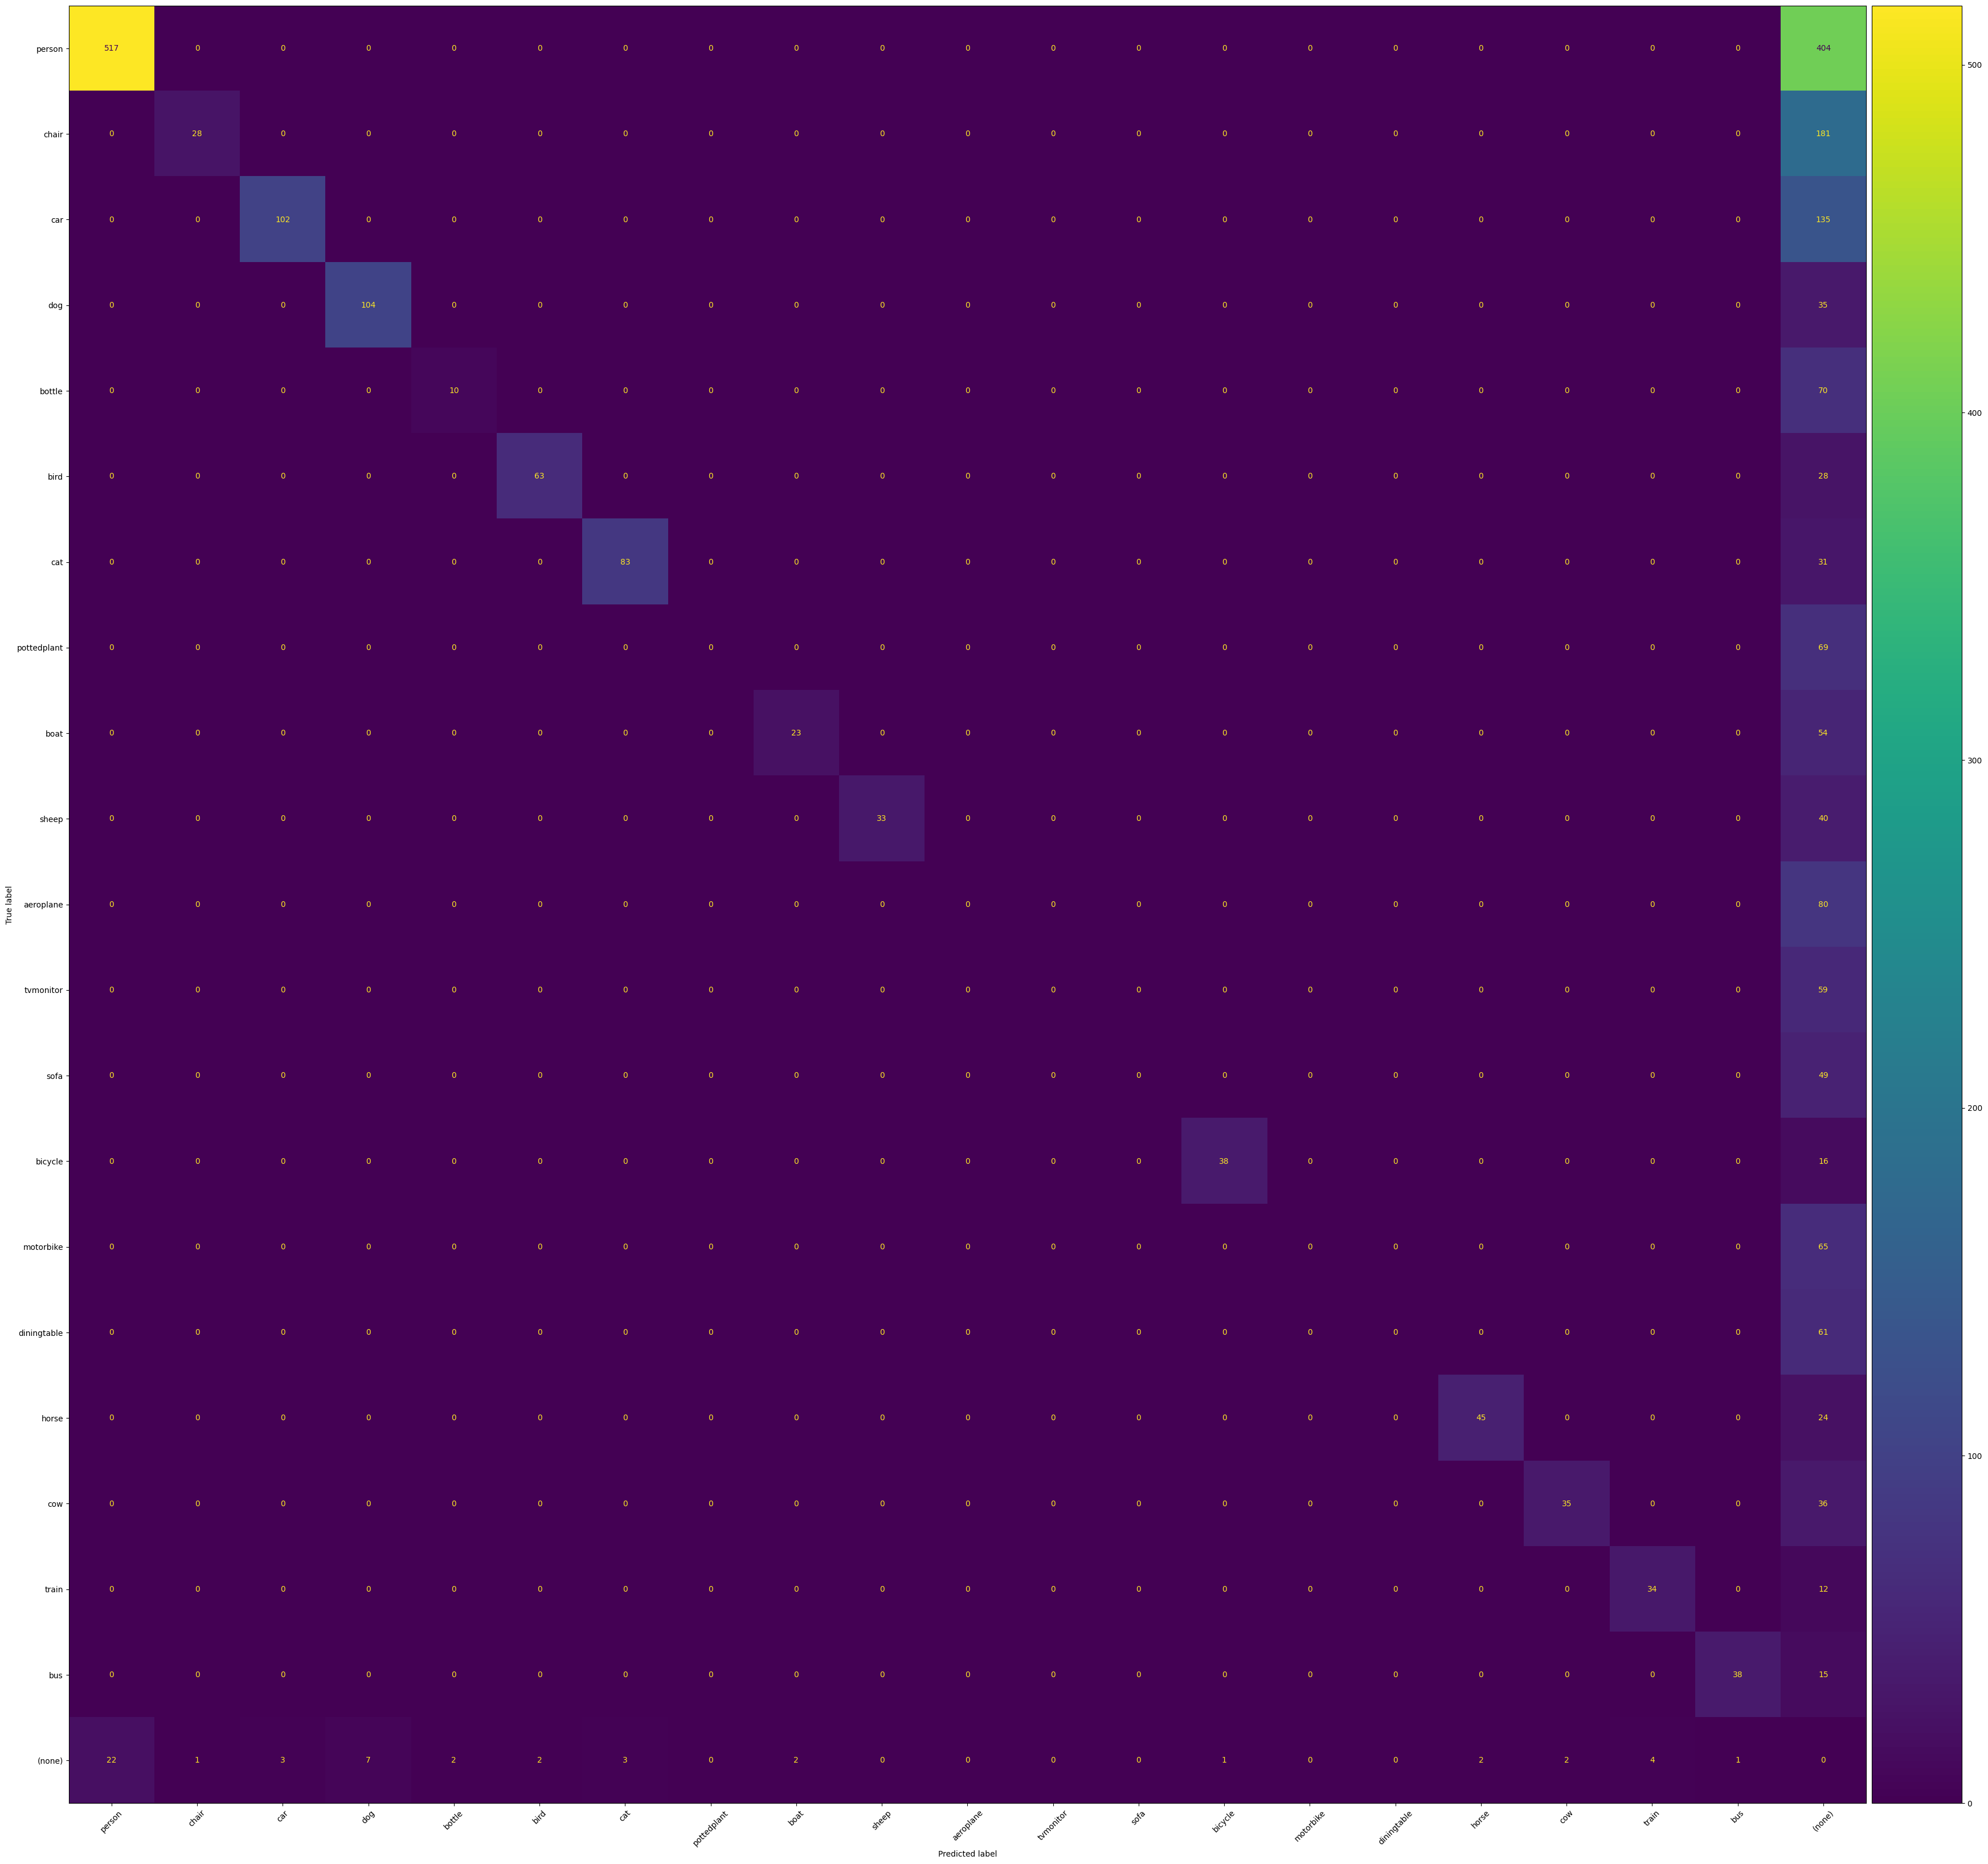

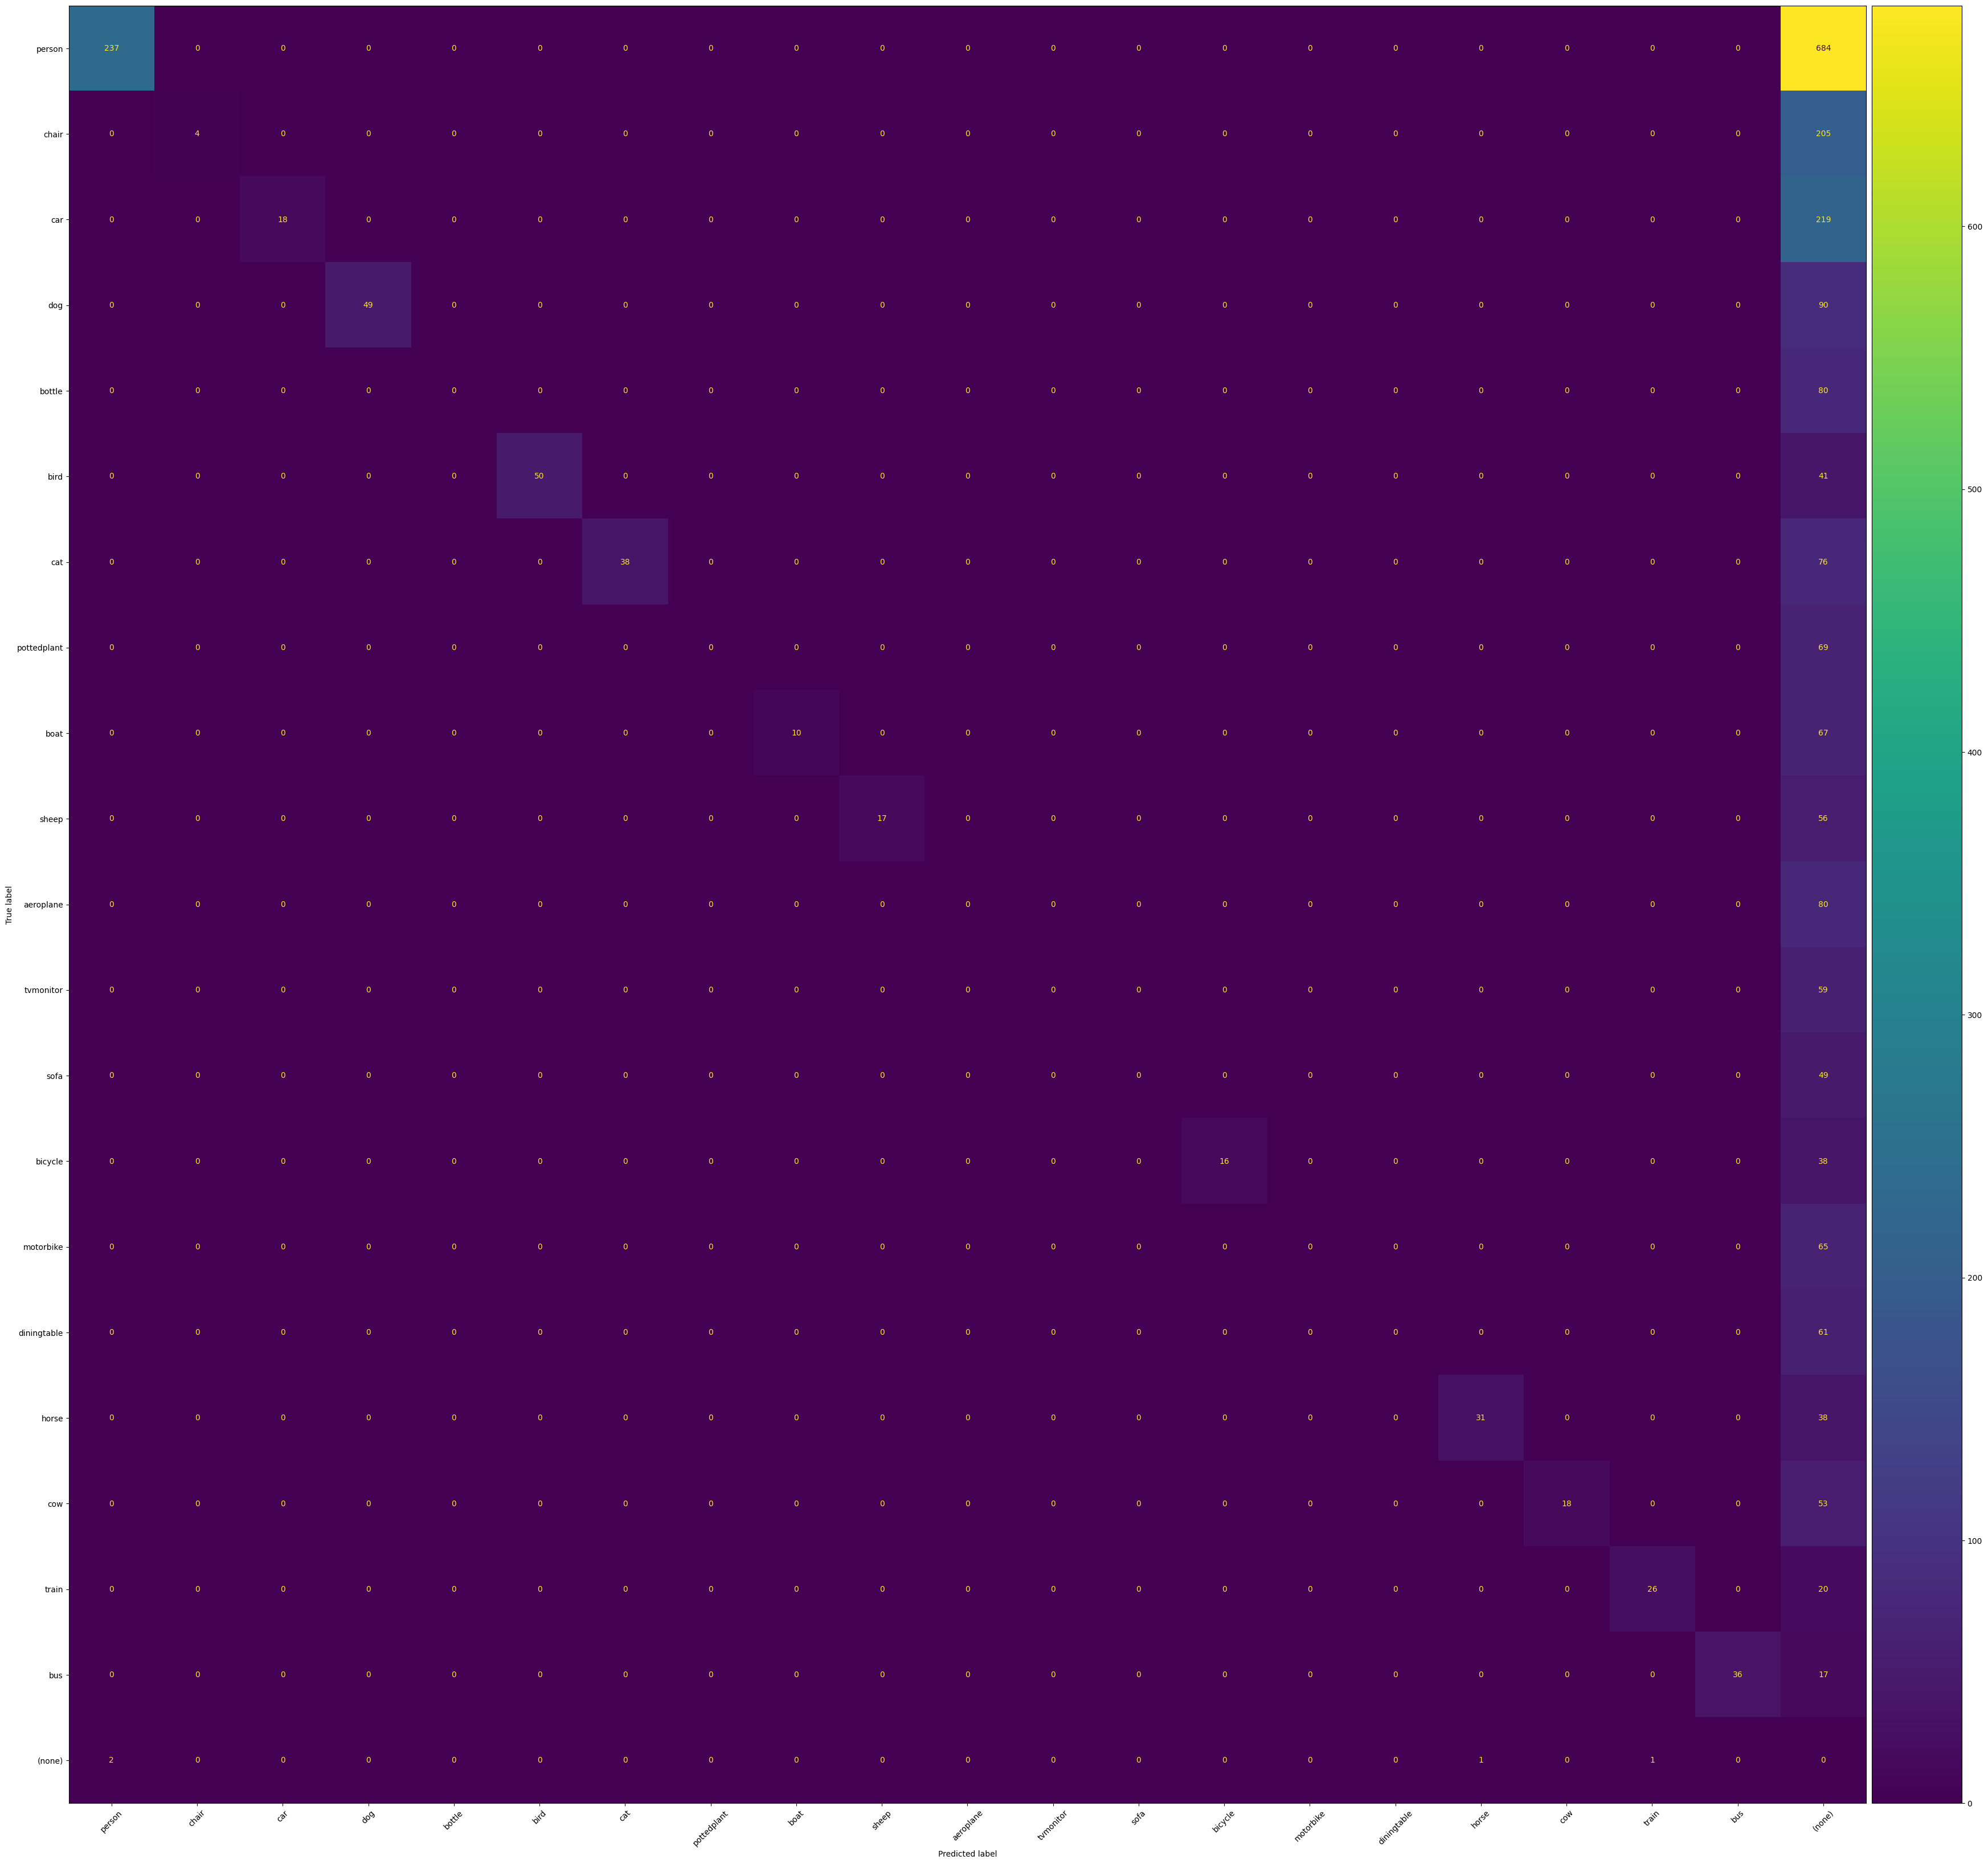

In [ ]:
from copy import deepcopy
counts = dataset.count_values("ground_truth.detections.label")
classes_sort = sorted(counts, key=counts.get, reverse=True)[:]
confidence_thresholds = [None, 0.5, 0.75,0.9]  # Include None for the initial evaluation without confidence filtering

for threshold in confidence_thresholds:
    if threshold is None:
        predictions_filtered = predictions_view
    else:
        predictions_filtered = predictions_view.filter_labels("ratina_net", F("confidence") >= threshold, only_matches=False)

    eval_result = predictions_filtered.evaluate_detections(
        "ratina_net",
        gt_field="ground_truth",
        eval_key="eval_2",
        compute_mAP=True,
    )

    calc_map(eval_result)

    d = eval_result.metrics(classes_sort)
    acc = d['accuracy']
    pre = d['precision']
    rec = d['recall']
    fsc = d['fscore']

    print(f'For confidence threshold {threshold}:')
    print('accuracy : ', acc)
    print('precision : ', pre)
    print('recall : ', rec)
    print('fscore : ', fsc)

    plot = eval_result.plot_confusion_matrix(classes=classes_sort[:], backend="matplotlib", figsize=(35, 35))
    plot.show()

    plot = eval_result.plot_confusion_matrix(classes=classes_sort[:10])
    plot.show()

    eval_patches = predictions_filtered.to_evaluation_patches("eval")
    print(eval_patches.count_values("type"))

    iou = eval_patches.count_values('iou')
    x = list(iou.items())
    sum_iou = 0.0
    for i, v in x:
        if not i:
            continue
        sum_iou += (i * v)

    print('IOU Score', sum_iou / sum(iou.values()))

    if threshold is not None:
        print(f"Number of predictions with confidence >= {threshold}: {sum(iou.values())}")


# **SSD Model**

Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 1000/1000 [20.9s elapsed, 0s remaining, 65.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [20.9s elapsed, 0s remaining, 65.1 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 1000/1000 [10.8s elapsed, 0s remaining, 122.0 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [10.8s elapsed, 0s remaining, 122.0 samples/s]      


mAP :  0.3242646787865101
              precision    recall  f1-score   support

      person       0.74      0.77      0.76       921
       chair       0.47      0.49      0.48       209
         car       0.80      0.70      0.75       237
         dog       0.77      0.88      0.82       139
      bottle       0.45      0.36      0.40        80
        bird       0.76      0.79      0.77        91
         cat       0.77      0.89      0.83       114
 pottedplant       0.00      0.00      0.00        69
        boat       0.62      0.52      0.56        77
       sheep       0.68      0.66      0.67        73
   aeroplane       0.00      0.00      0.00        80
   tvmonitor       0.00      0.00      0.00        59
        sofa       0.00      0.00      0.00        49
     bicycle       0.73      0.80      0.76        54
   motorbike       0.00      0.00      0.00        65
 diningtable       0.00      0.00      0.00        61
       horse       0.77      0.88      0.82        69
 

For confidence threshold 0.2:
accuracy :  0.4980067463968108
precision :  0.7160493827160493
recall :  0.6205578907145587
fscore :  0.66489252814739


/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



{'tp': 1559, 'fp': 897, 'fn': 1058, None: 21119}
IOU Score 0.053130498461261076
Number of predictions with confidence >= 0.2: 24633
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 1000/1000 [13.7s elapsed, 0s remaining, 90.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [13.7s elapsed, 0s remaining, 90.9 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 1000/1000 [9.4s elapsed, 0s remaining, 144.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [9.4s elapsed, 0s remaining, 144.4 samples/s]      


mAP :  0.2807325824312871
              precision    recall  f1-score   support

      person       0.92      0.59      0.72       921
       chair       0.80      0.34      0.48       209
         car       0.94      0.51      0.66       237
         dog       0.94      0.82      0.88       139
      bottle       0.86      0.15      0.26        80
        bird       0.98      0.64      0.77        91
         cat       0.91      0.81      0.86       114
 pottedplant       0.00      0.00      0.00        69
        boat       0.93      0.32      0.48        77
       sheep       0.88      0.48      0.62        73
   aeroplane       0.00      0.00      0.00        80
   tvmonitor       0.00      0.00      0.00        59
        sofa       0.00      0.00      0.00        49
     bicycle       0.95      0.72      0.82        54
   motorbike       0.00      0.00      0.00        65
 diningtable       0.00      0.00      0.00        61
       horse       0.98      0.74      0.84        69
 

For confidence threshold 0.5:
accuracy :  0.4633431085043988
precision :  0.9192727272727272
recall :  0.48299579671379445
fscore :  0.6332665330661323


/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



{'fn': 1058, 'tp': 1559, 'fp': 897, None: 21119}
IOU Score 0.053130498461261055
Number of predictions with confidence >= 0.5: 24633
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 1000/1000 [12.4s elapsed, 0s remaining, 97.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [12.4s elapsed, 0s remaining, 97.4 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 1000/1000 [7.1s elapsed, 0s remaining, 134.3 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [7.1s elapsed, 0s remaining, 134.3 samples/s]      


mAP :  0.24449797771875748
              precision    recall  f1-score   support

      person       0.97      0.45      0.61       921
       chair       0.92      0.22      0.36       209
         car       0.97      0.38      0.55       237
         dog       0.94      0.70      0.80       139
      bottle       1.00      0.06      0.12        80
        bird       0.98      0.55      0.70        91
         cat       0.97      0.75      0.84       114
 pottedplant       0.00      0.00      0.00        69
        boat       1.00      0.21      0.34        77
       sheep       0.94      0.40      0.56        73
   aeroplane       0.00      0.00      0.00        80
   tvmonitor       0.00      0.00      0.00        59
        sofa       0.00      0.00      0.00        49
     bicycle       1.00      0.63      0.77        54
   motorbike       0.00      0.00      0.00        65
 diningtable       0.00      0.00      0.00        61
       horse       0.98      0.62      0.76        69


For confidence threshold 0.75:
accuracy :  0.3770244821092279
precision :  0.9634263715110684
recall :  0.38249904470768054
fscore :  0.5475929978118163


/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



{None: 21119, 'tp': 1559, 'fn': 1058, 'fp': 897}
IOU Score 0.053130498461261076
Number of predictions with confidence >= 0.75: 24633
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 1000/1000 [10.5s elapsed, 0s remaining, 74.2 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [10.5s elapsed, 0s remaining, 74.2 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 1000/1000 [7.8s elapsed, 0s remaining, 163.7 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [7.8s elapsed, 0s remaining, 163.7 samples/s]      


mAP :  0.20730636022016471
              precision    recall  f1-score   support

      person       0.99      0.32      0.49       921
       chair       1.00      0.13      0.24       209
         car       0.98      0.24      0.38       237
         dog       0.96      0.50      0.66       139
      bottle       1.00      0.04      0.07        80
        bird       0.98      0.48      0.65        91
         cat       1.00      0.61      0.75       114
 pottedplant       0.00      0.00      0.00        69
        boat       1.00      0.17      0.29        77
       sheep       0.96      0.33      0.49        73
   aeroplane       0.00      0.00      0.00        80
   tvmonitor       0.00      0.00      0.00        59
        sofa       0.00      0.00      0.00        49
     bicycle       1.00      0.54      0.70        54
   motorbike       0.00      0.00      0.00        65
 diningtable       0.00      0.00      0.00        61
       horse       1.00      0.51      0.67        69


For confidence threshold 0.9:
accuracy :  0.28756181057436286
precision :  0.984375
recall :  0.28888039740160487
fscore :  0.4466765140324963


/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1575: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



{'fp': 897, 'tp': 1559, None: 21119, 'fn': 1058}
IOU Score 0.05313049846126108
Number of predictions with confidence >= 0.9: 24633


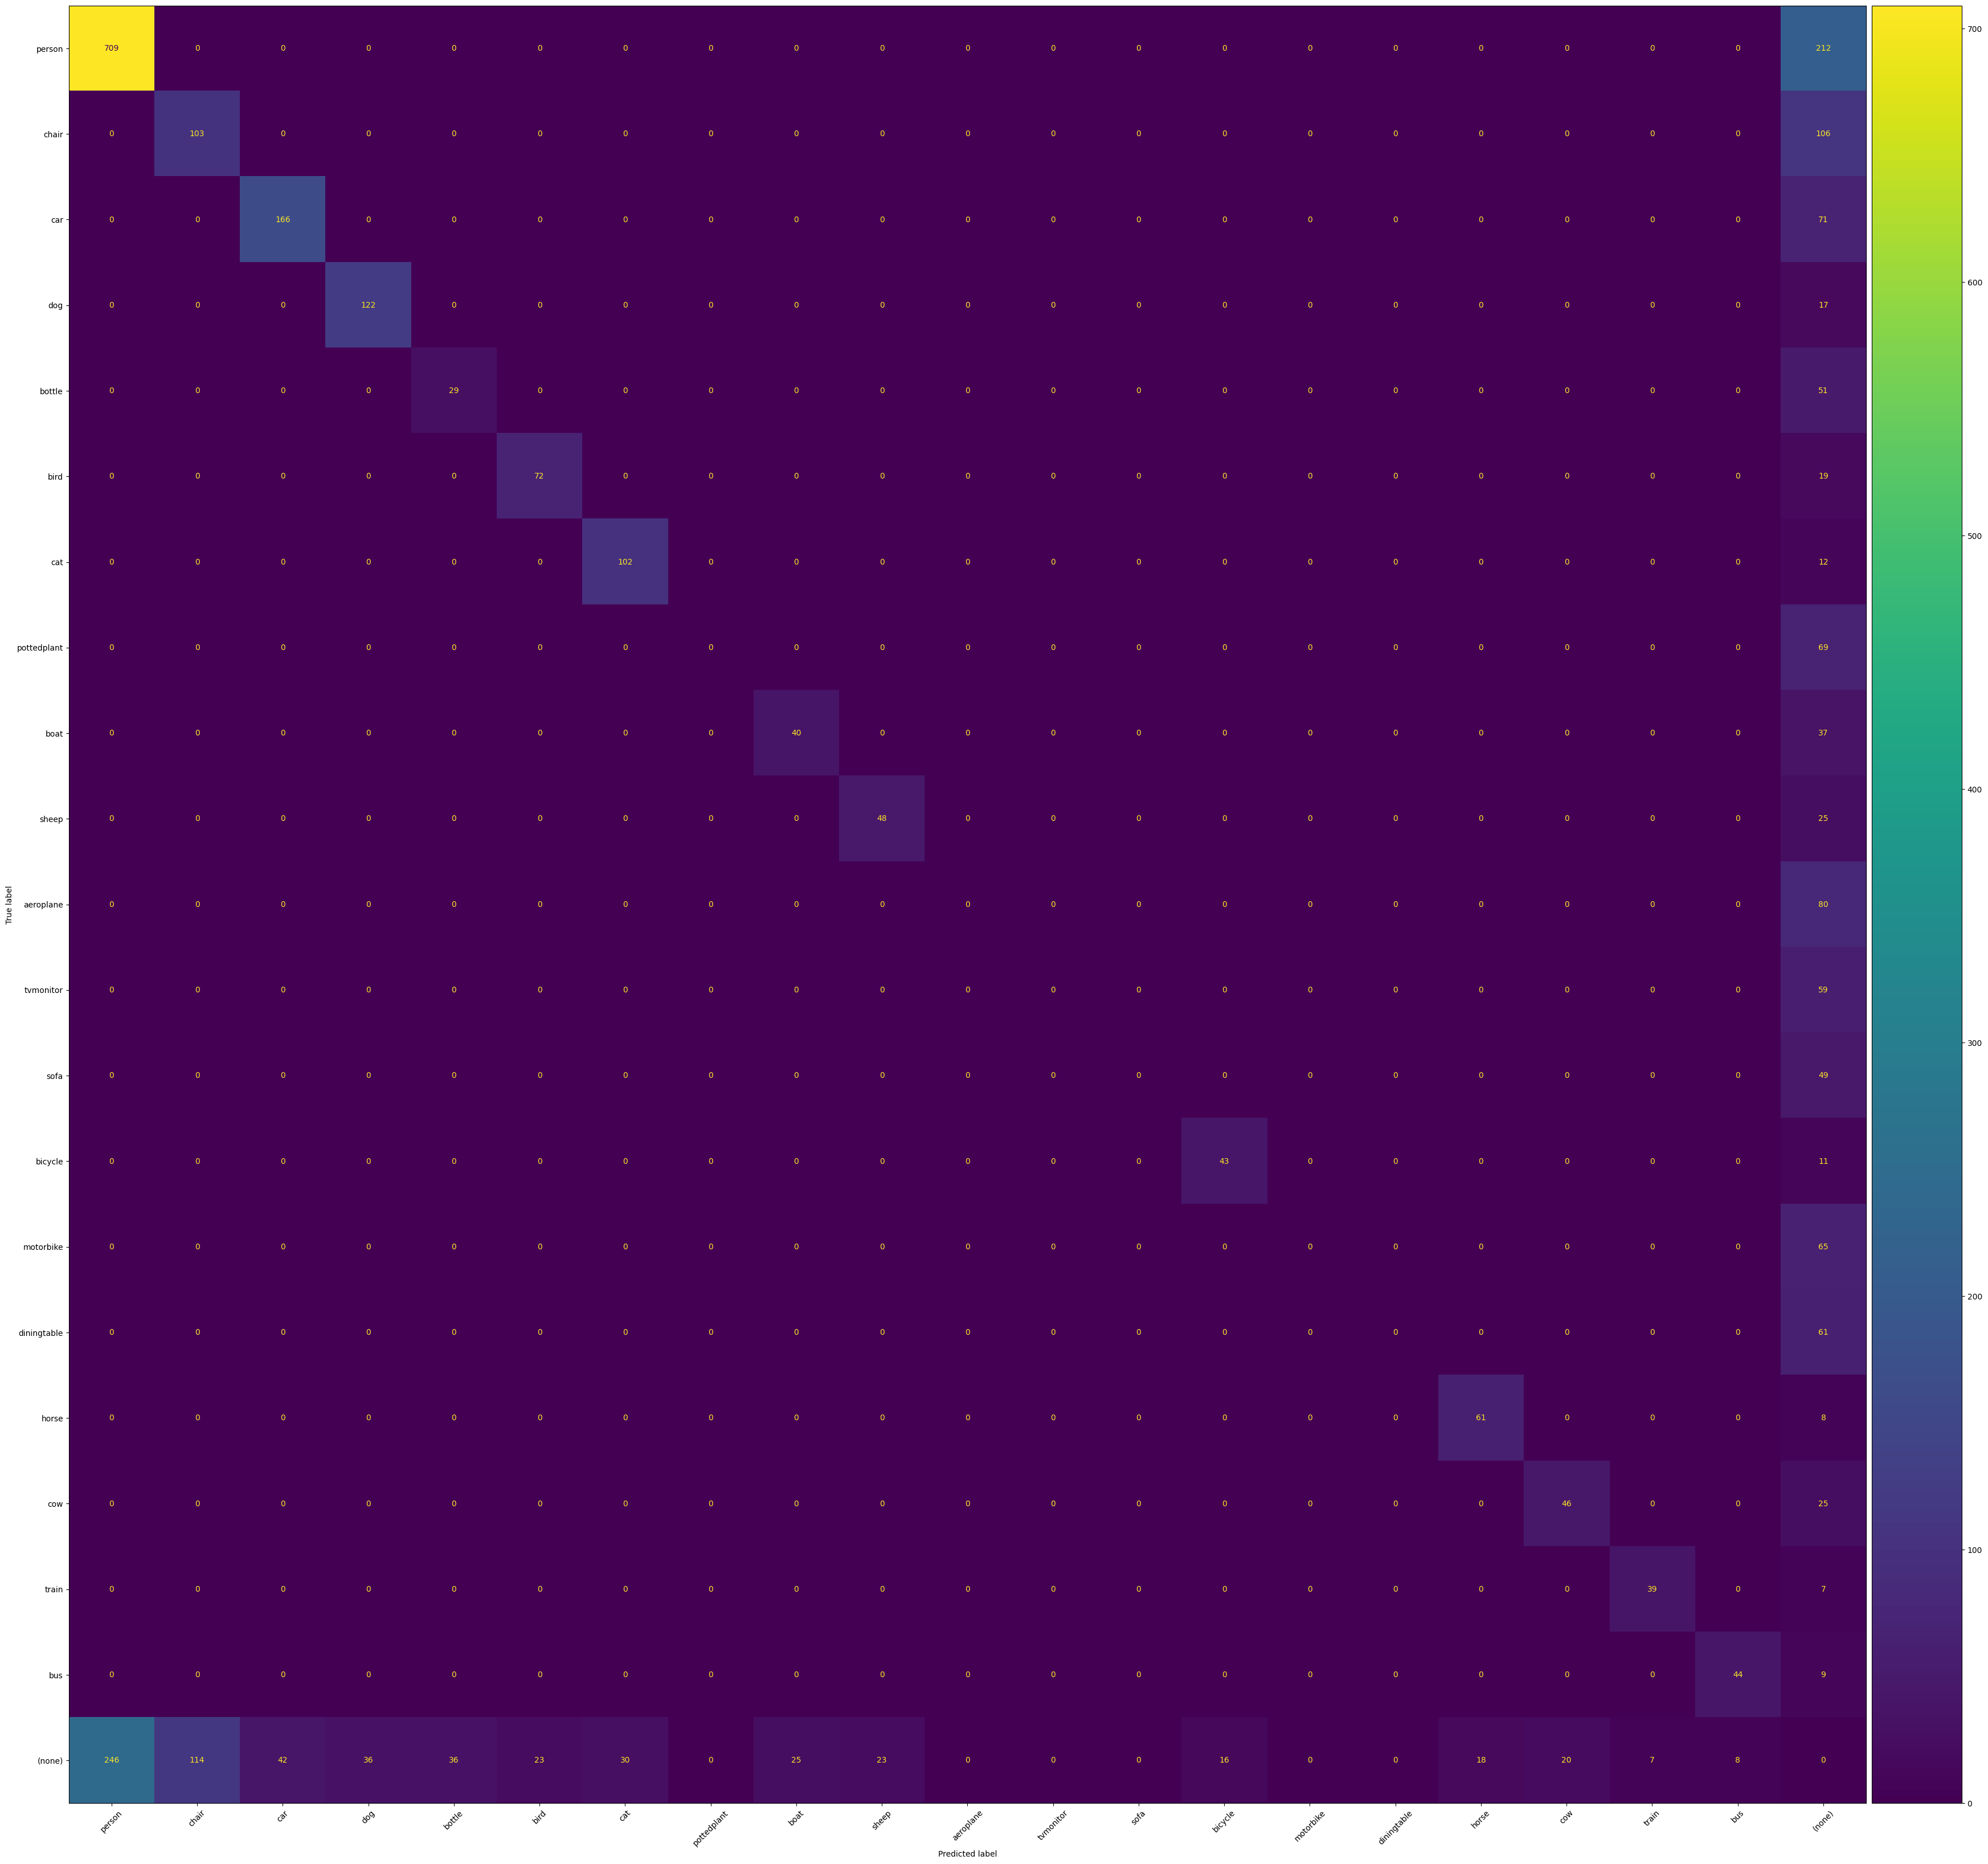

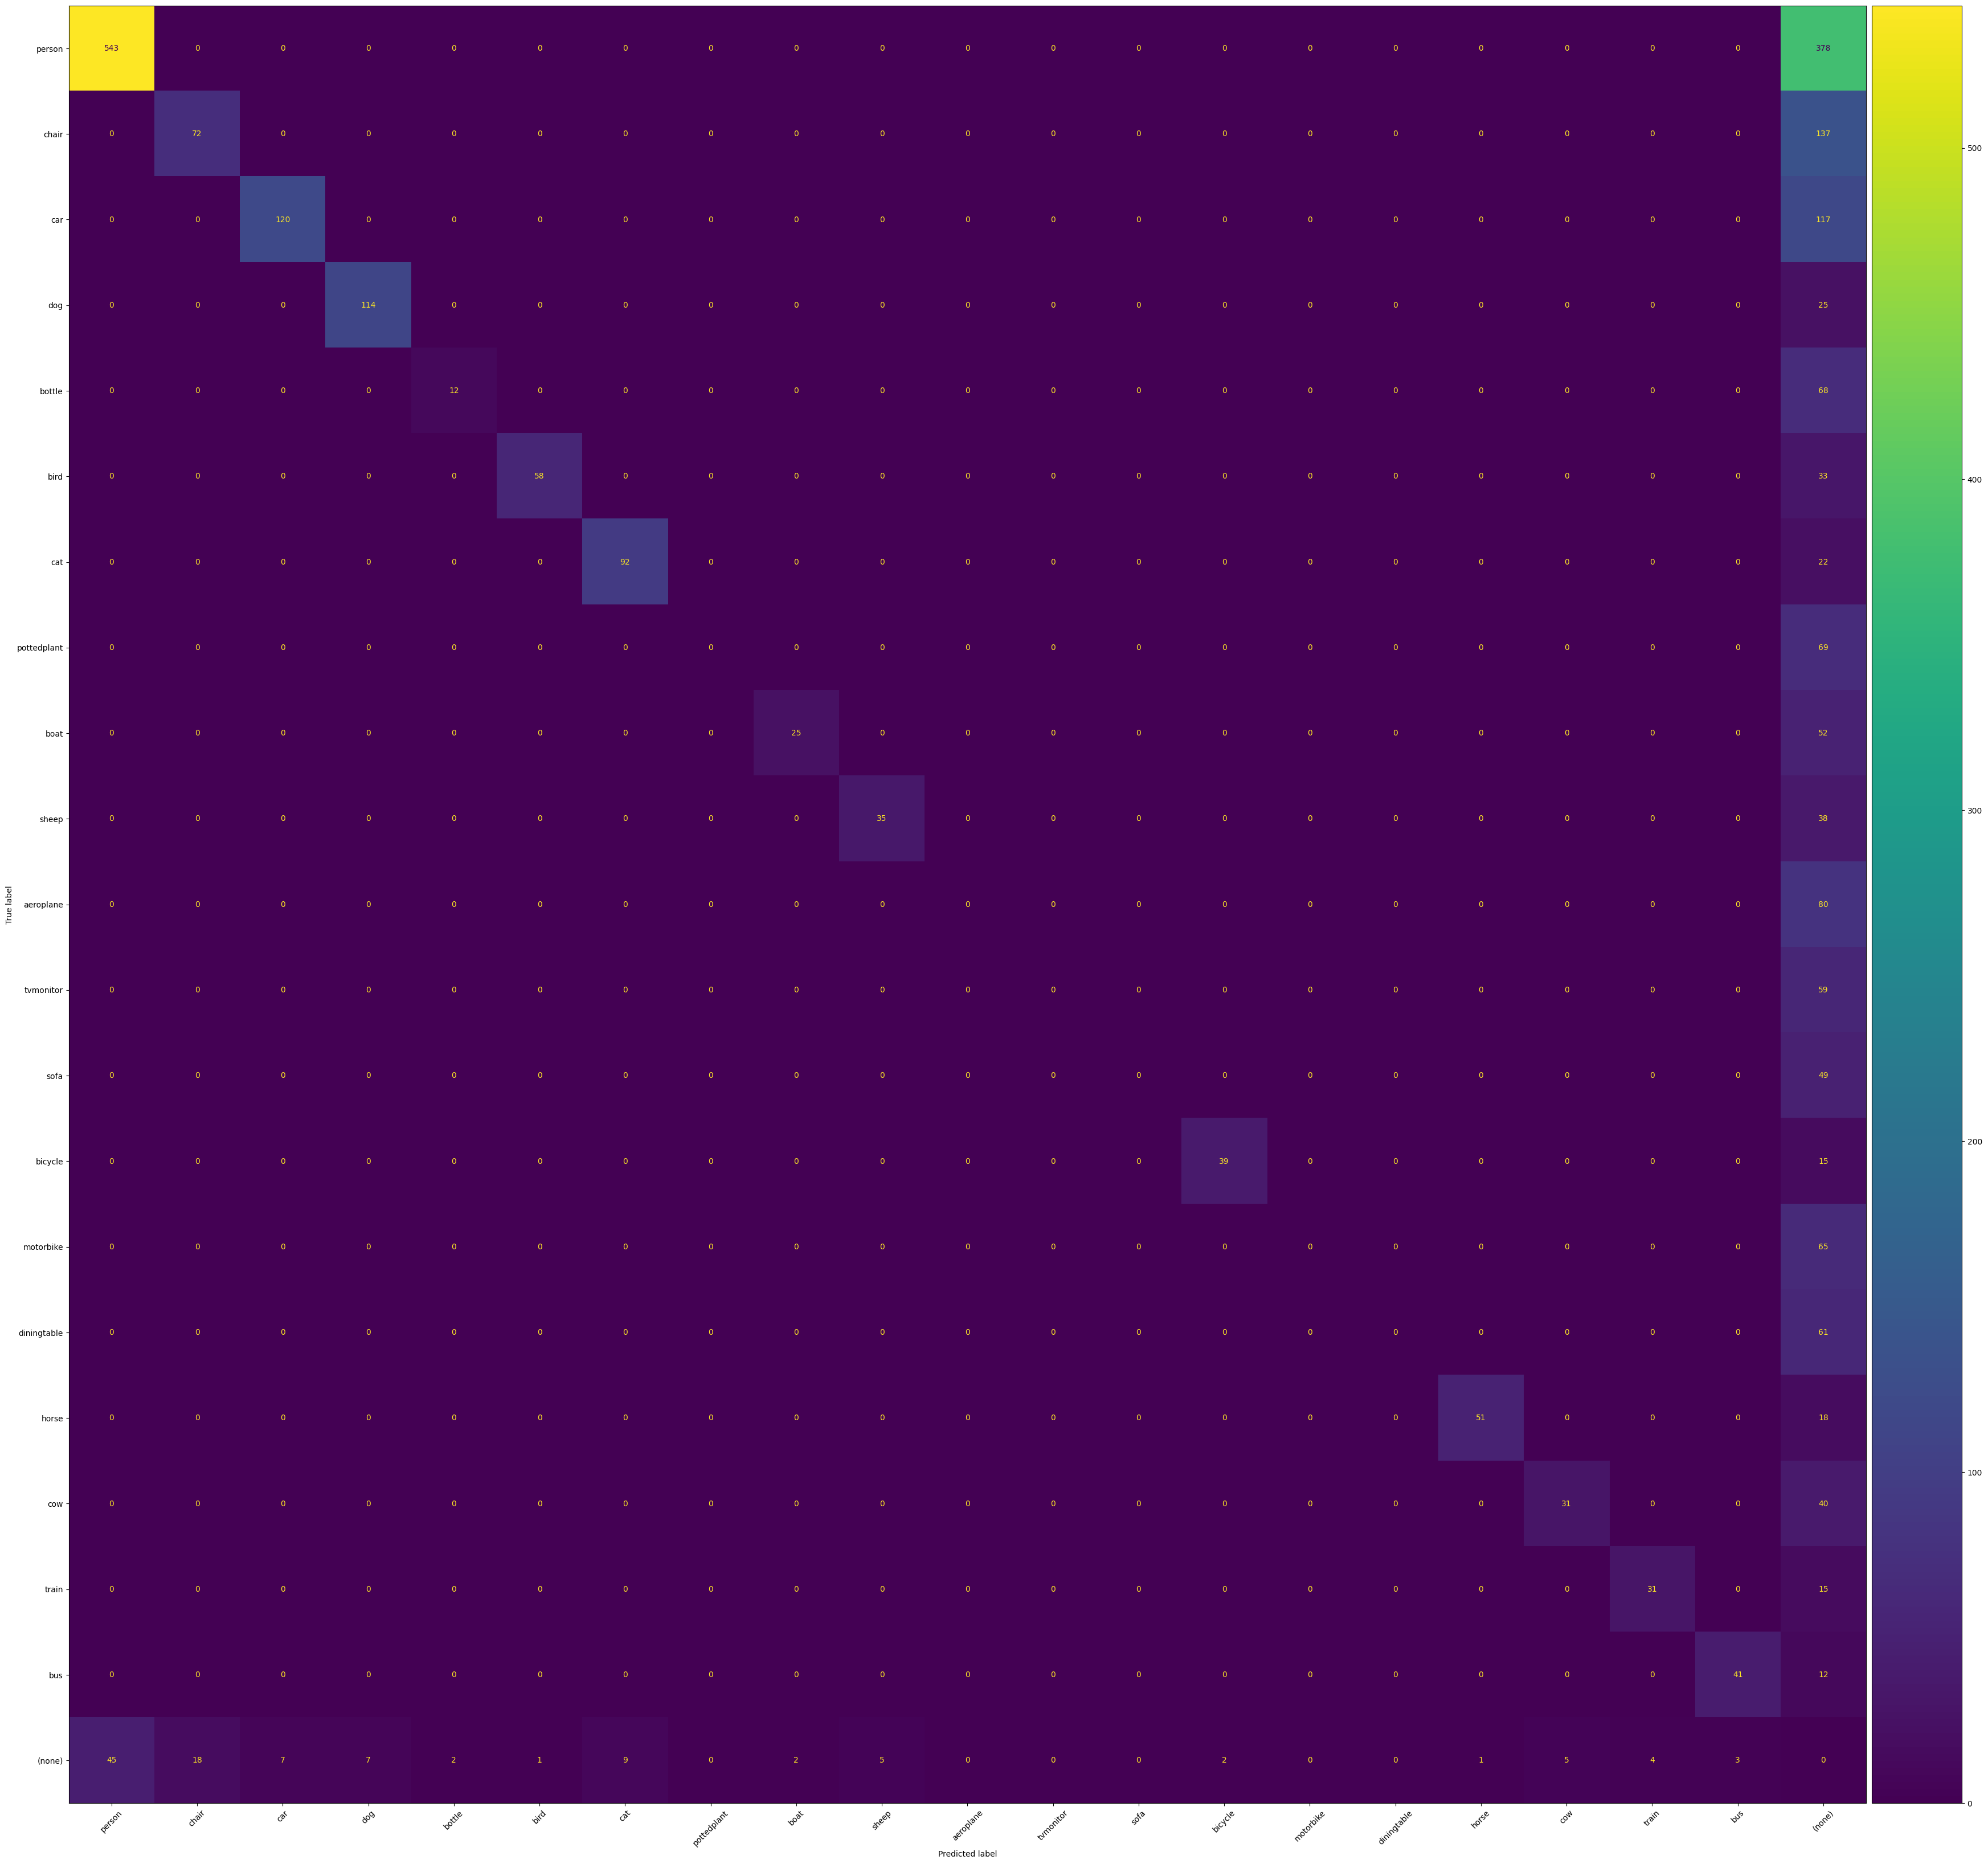

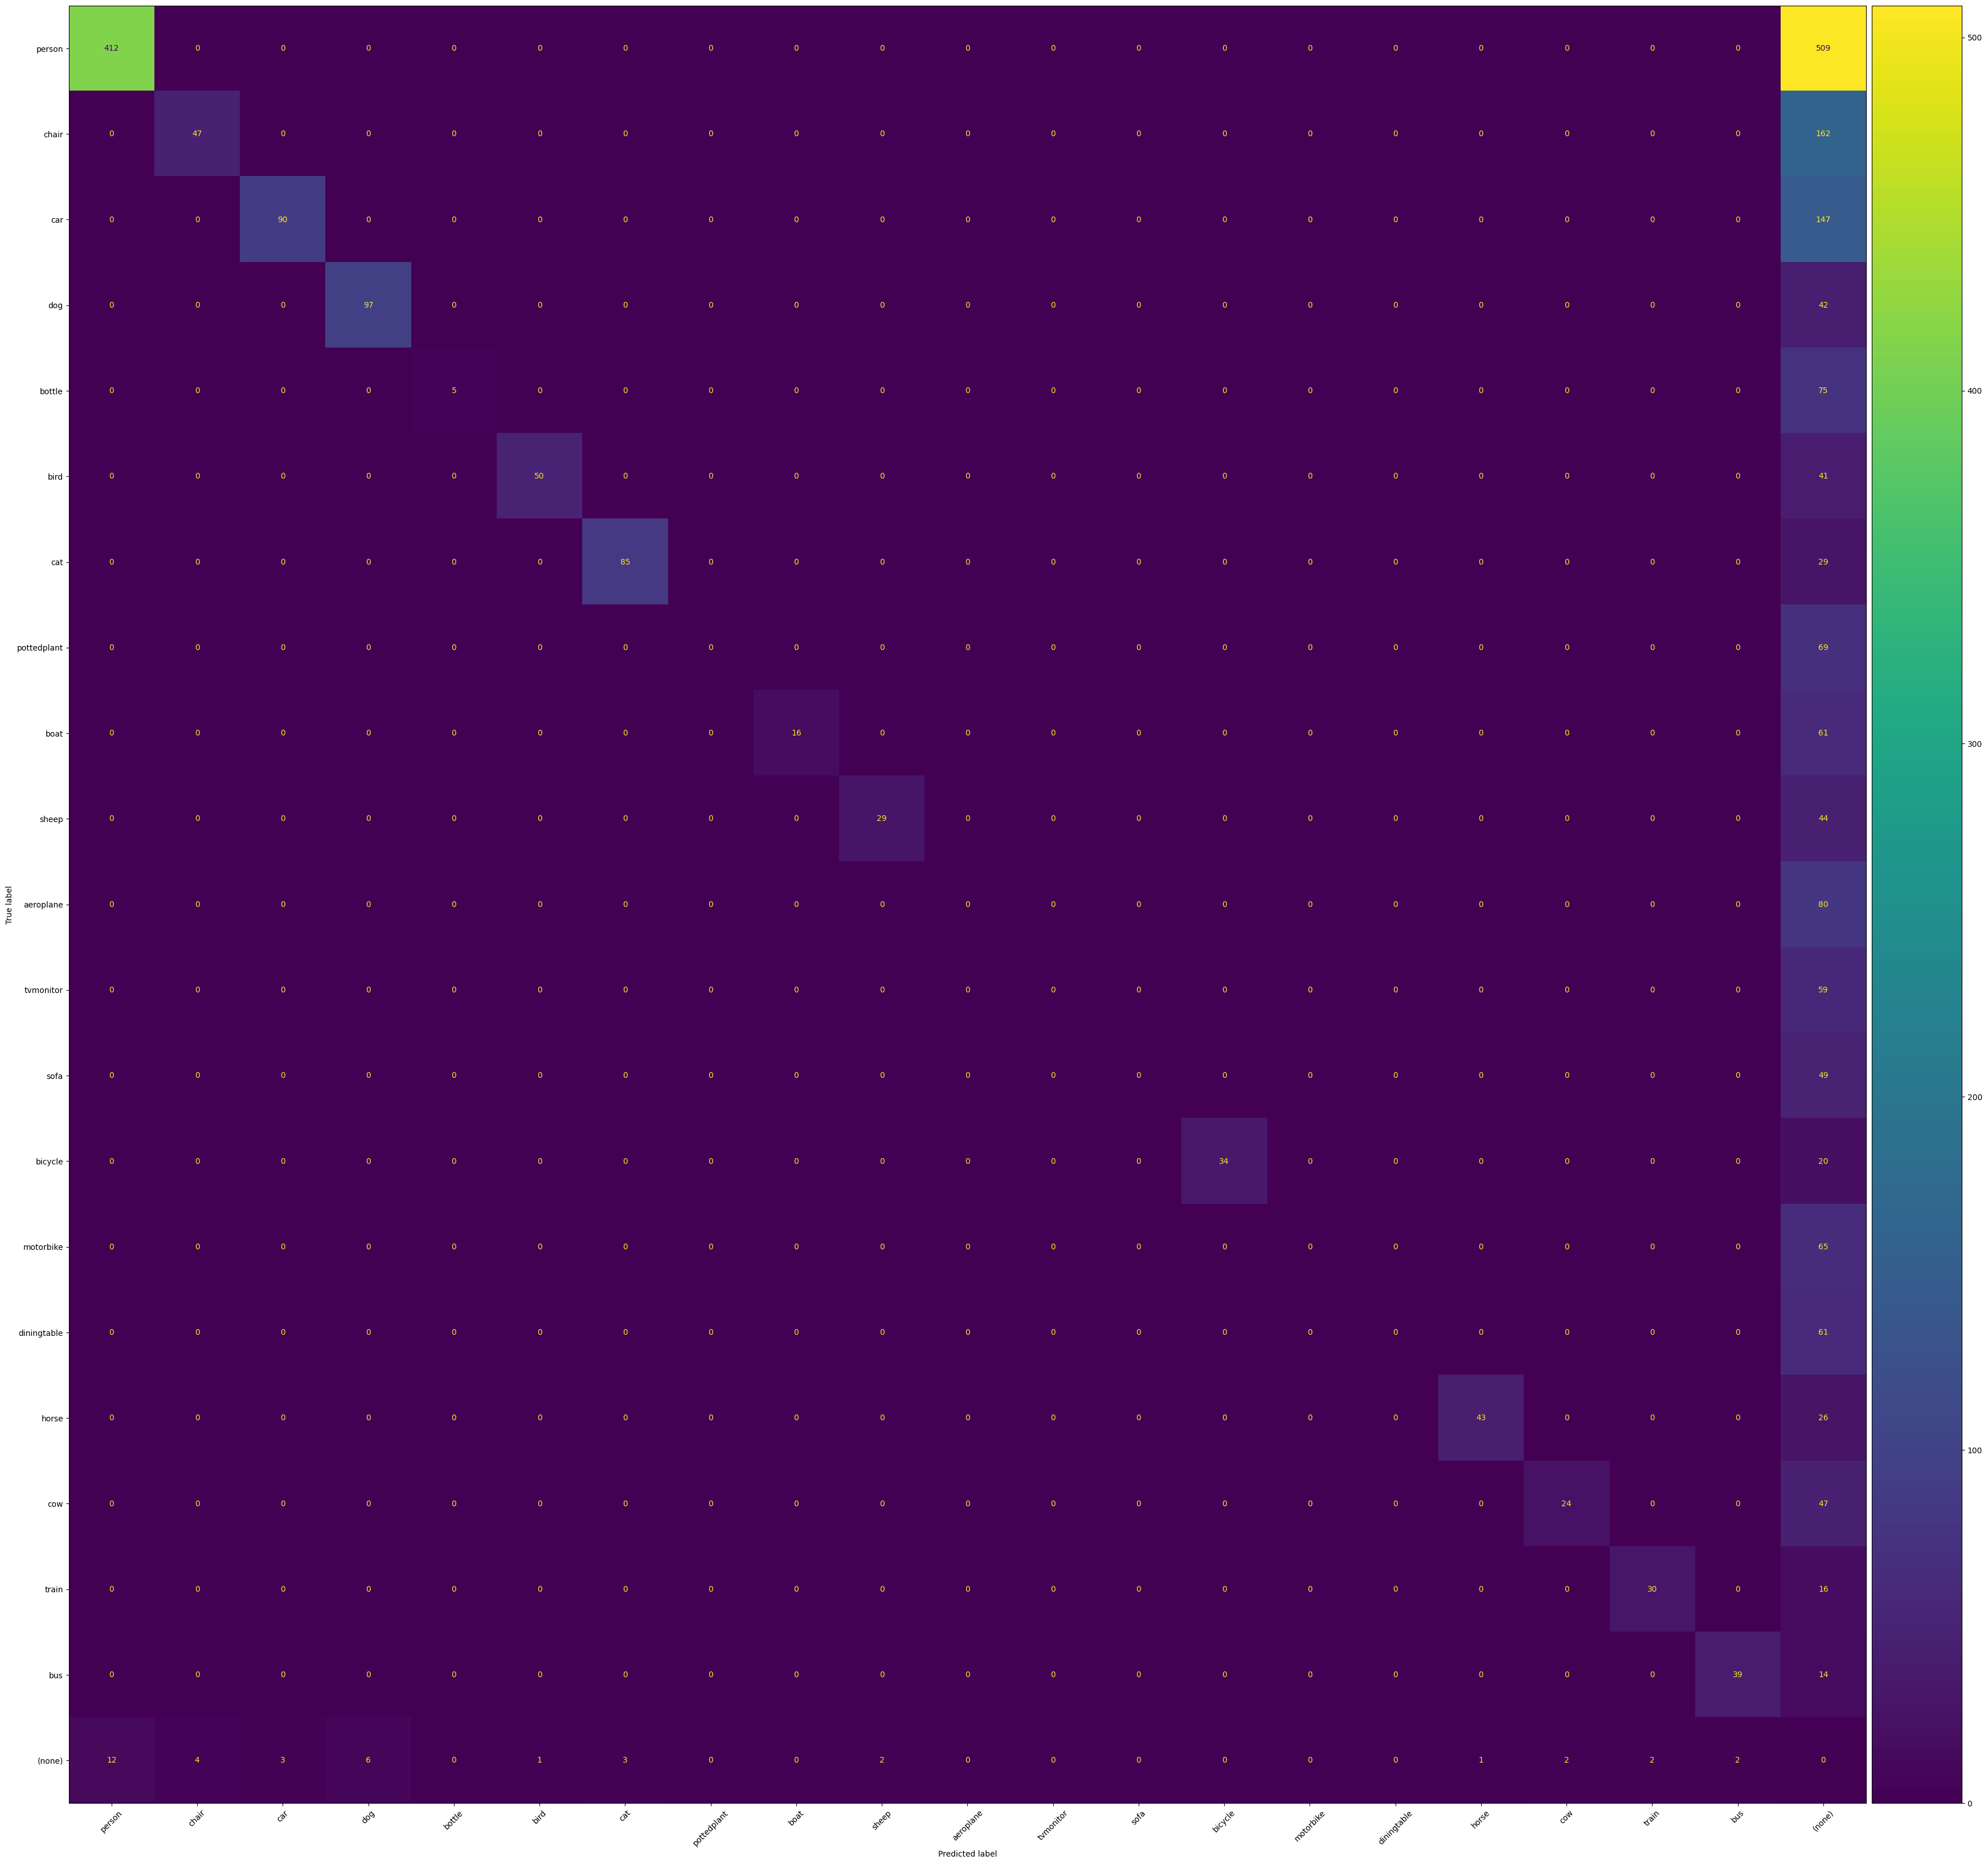

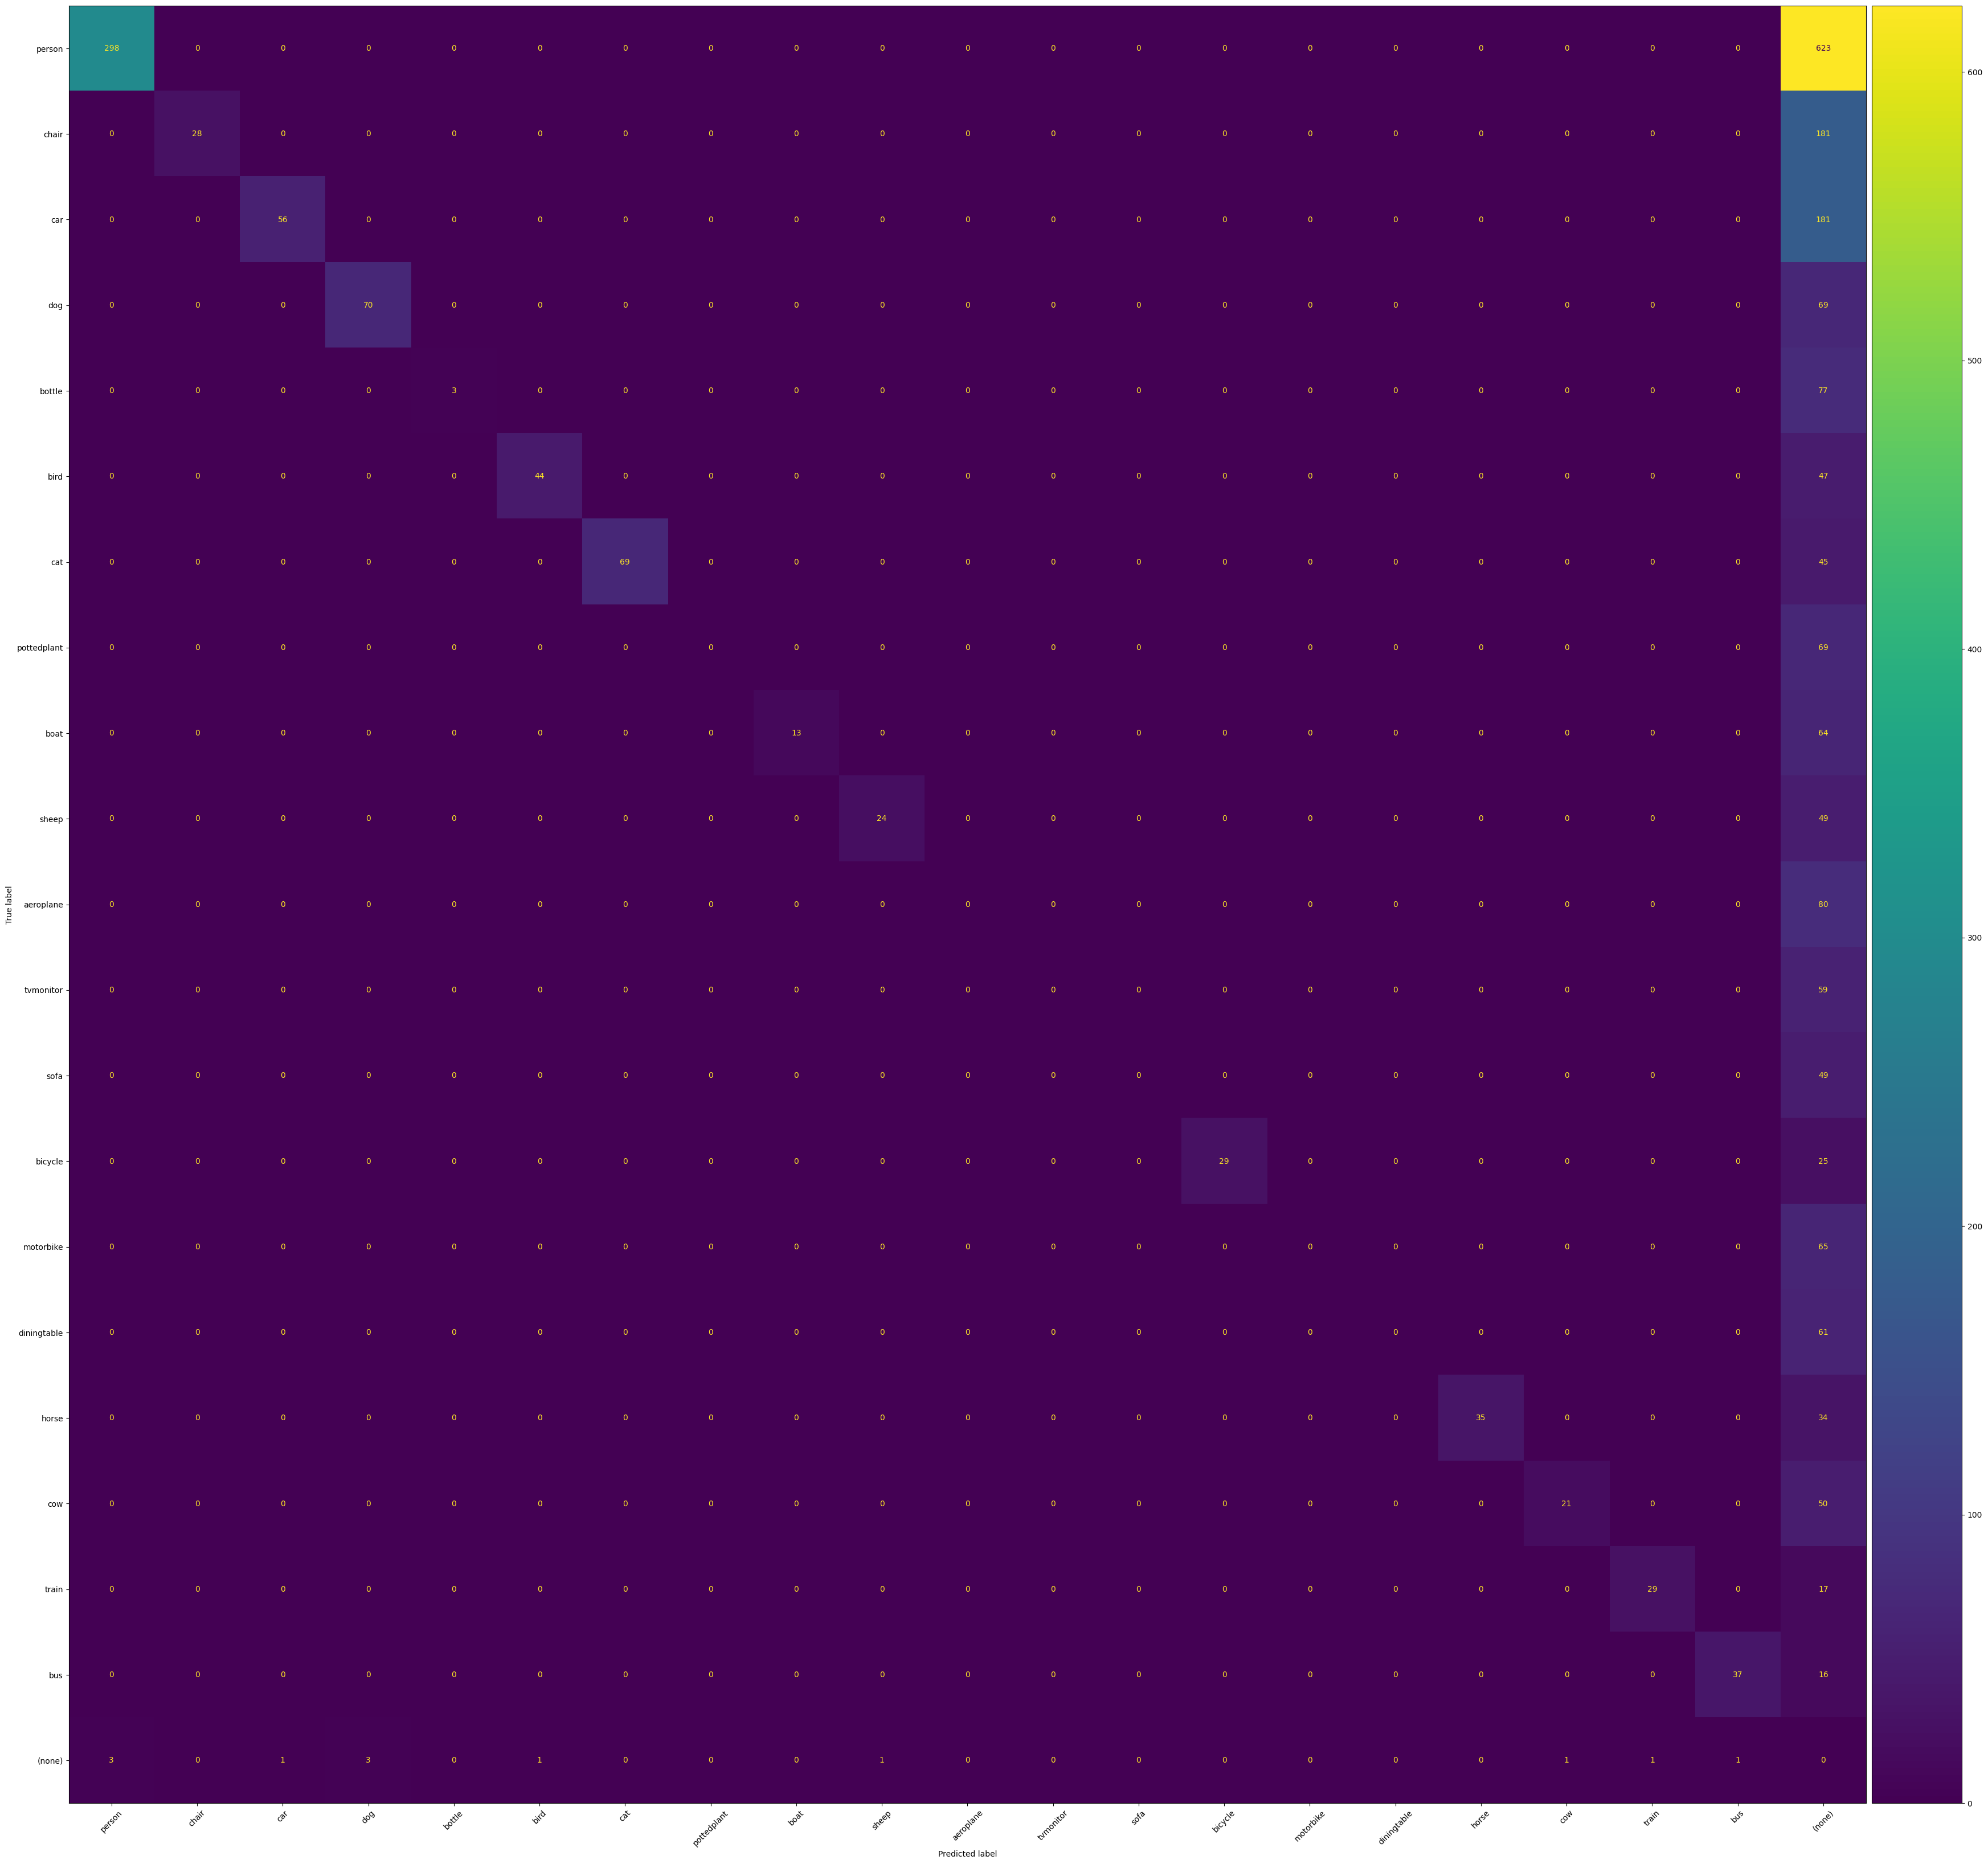

In [ ]:
from copy import deepcopy
counts = dataset.count_values("ground_truth.detections.label")
classes_sort = sorted(counts, key=counts.get, reverse=True)[:]
confidence_thresholds = [0.2, 0.5, 0.75,0.9]  # Include None for the initial evaluation without confidence filtering

for threshold in confidence_thresholds:
    if threshold is None:
        predictions_filtered = predictions_view
    else:
        predictions_filtered = predictions_view.filter_labels("ssd_model", F("confidence") >= threshold, only_matches=False)

    eval_result = predictions_filtered.evaluate_detections(
        "ssd_model",
        gt_field="ground_truth",
        eval_key="eval_3",
        compute_mAP=True,
    )

    calc_map(eval_result)

    d = eval_result.metrics(classes_sort)
    acc = d['accuracy']
    pre = d['precision']
    rec = d['recall']
    fsc = d['fscore']

    print(f'For confidence threshold {threshold}:')
    print('accuracy : ', acc)
    print('precision : ', pre)
    print('recall : ', rec)
    print('fscore : ', fsc)

    plot = eval_result.plot_confusion_matrix(classes=classes_sort[:], backend="matplotlib", figsize=(35, 35))
    plot.show()

    plot = eval_result.plot_confusion_matrix(classes=classes_sort[:10])
    plot.show()

    eval_patches = predictions_filtered.to_evaluation_patches("eval")
    print(eval_patches.count_values("type"))

    iou = eval_patches.count_values('iou')
    x = list(iou.items())
    sum_iou = 0.0
    for i, v in x:
        if not i:
            continue
        sum_iou += (i * v)

    print('IOU Score', sum_iou / sum(iou.values()))

    if threshold is not None:
        print(f"Number of predictions with confidence >= {threshold}: {sum(iou.values())}")
